# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1. Compute Camera Calibration using chessboard images

Image distortion occurs when a camera looks at 3D objects in the real world and transforms them into a 2D image; this transformation isn’t perfect. Distortion actually changes what the shape and size of these 3D objects appear to be. So, the first step in analyzing camera images, is to undo this distortion so that it we can get correct and useful information out of them

I prepare "object points", which will be the 3D coordinates of the chessboard corners in the world. Here the given chessboard images has fixed on the 2D(9, 6) plane at z=0, such that the object points are the same for each calibration image. Thus, objp is just a replicated array of coordinates, and objpoints will be appended with a copy of it every time I successfully detect all chessboard corners in a test image. imgpoints will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.

I then used the output objpoints and imgpoints to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function. I applied this distortion correction to the test image using the cv2.undistort() function and obtained this result:
### Compute object and image points

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
#%matplotlib qt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

cv2.destroyAllWindows()


### Calibrate the Camera

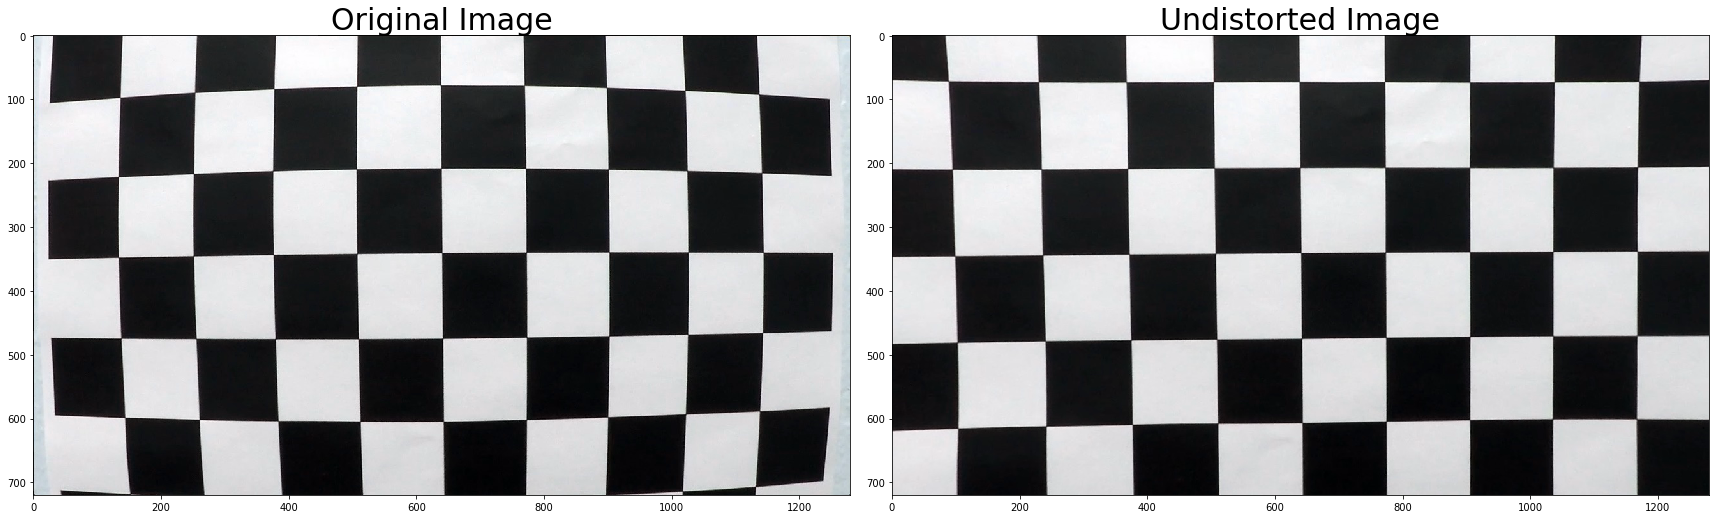

In [2]:
'''
1. Camera Calibration
'''

img = cv2.imread('../camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Find the Camera calibration Once given object points, image points(derived 
#above line 1-32) and the shape of the grayscale image:
ret, mtx, dist, rvesc, tvecs = cv2.calibrateCamera(objpoints, imgpoints, \
                                                   img_size, None, None)

# Above function return distortion coffecient(dist), cameera matrix (mtx)
# and rotation and translation vector in real world and these information will be used 
# in section bellow to correct the distortion of an image
undistort = cv2.undistort(img, mtx, dist, None, mtx)


# Visualize the undistortion on a calibration image

f, (ax1, ax2) = plt.subplots(1,2, figsize=(24,9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize = 30)

ax2.imshow(undistort)
ax2.set_title('Undistorted Image', fontsize = 30)


## 2.  Provide an example of a distortion-corrected image 

Use the distortion coffecient, cameera matrix mtx ( to transform 3D objects points to 2D image points), rotation and translation vector calculated above to undistort the test images from the 'test_images' folder by calling the 
cv2.undistort function as bellow.


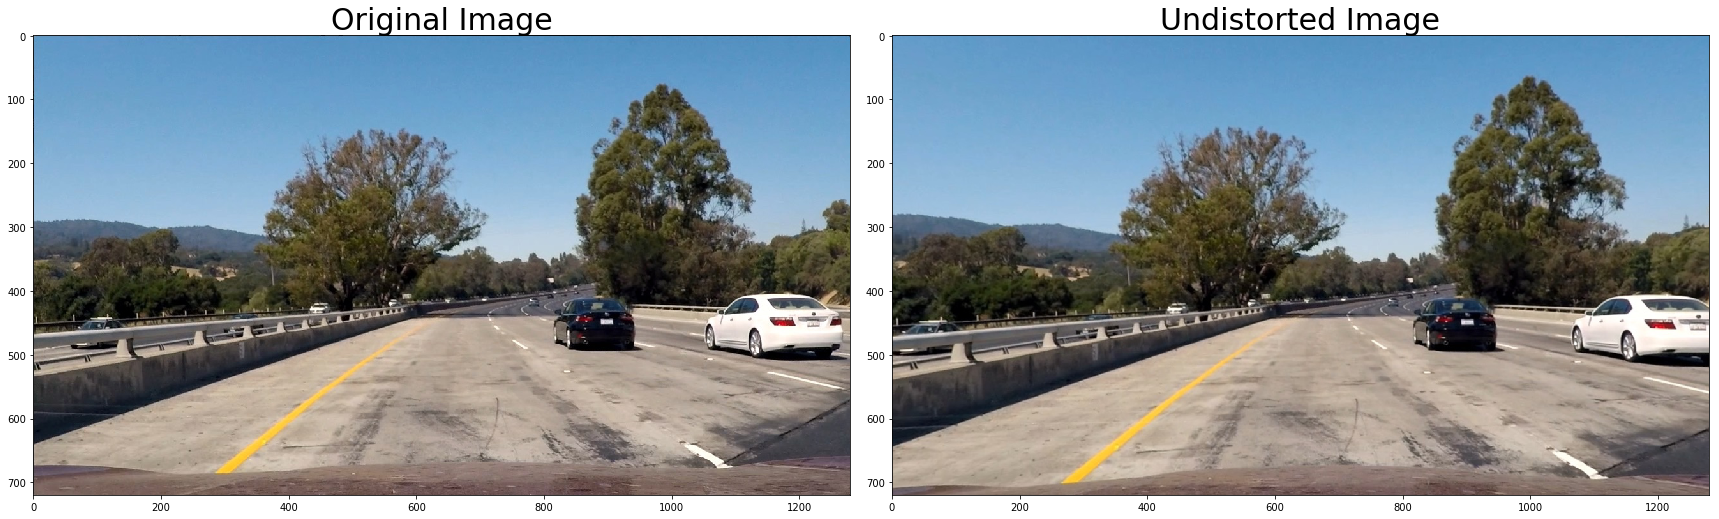

In [3]:
'''
Example of a distortion-corrected image.

undistort - undistorts an distorted image.
'''
def undistort(image):
    undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)
    return undistorted_image

#imread the image in RGB format.
test_img = mpimg.imread('../test_images/test1.jpg')

#undistort the image using 
img_undistort =  undistort(test_img)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(24,9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize = 30)

ax2.imshow(img_undistort)
ax2.set_title('Undistorted Image', fontsize = 30)

## 3. perspective transform with an example of a transformed image.

A perspective transform maps the points in a given image to different, desired, image points with a new perspective. This will be useful for calculating the lane curvature later on.


In [4]:
'''
warper - Transform the perspective of a given image using the source and destination points.
'''
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    
    #Transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

    #Inverse transform matrix
    Minv = cv2.getPerspectiveTransform(dst, src)

    # keep same size as input image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)

    return warped, M, Minv

The code for my perspective transform includes a function called warper(), which appears in lines 1 through 18 above. The warper() function takes as inputs an image (img), as well as source (src) and destination (dst) points. I chose the hardcode the source and destination points in the following manner:

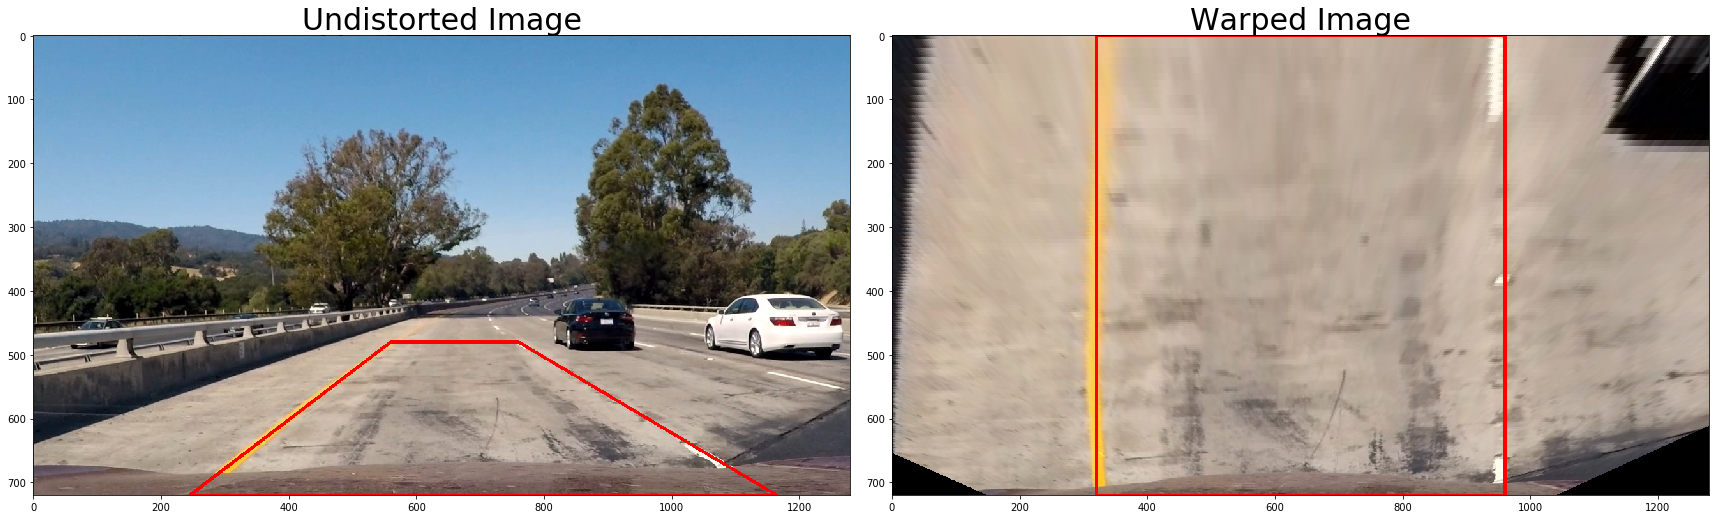

In [5]:

src = np.float32(
    [[(img_size[0] / 2) - 80, img_size[1] / 2 + 120], # top left
    [((img_size[0] / 4) - 75), img_size[1]],         # bottom left
    [(img_size[0] ) - 115, img_size[1]],             # bottom right
    [(img_size[0] / 2 + 120), img_size[1] / 2 + 120]] # top right
    )
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

warp_img, M, Minv = warper(img_undistort, src, dst)

# Draw src points on undistorted image
pts = np.array(src, np.int32)
pts = pts.reshape((-1,1,2))
cv2.polylines(test_img,[pts],True,(255,0,0), 3)

# Draw dst points on warp image
pts = np.array(dst, np.int32)
pts = pts.reshape((-1,1,2))
cv2.polylines(warp_img,[pts],True,(255,0,0), 3)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(24,9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Undistorted Image', fontsize = 30)

ax2.imshow(warp_img)
ax2.set_title('Warped Image', fontsize = 30)


I verified that my perspective transform was working as expected by drawing the src and dst points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image as above

## 4. Color transforms, Gradients or other methods to create a thresholded binary image

I used a combination of color and gradient thresholds to generate a binary image (bellow). Althouhg I tried with differen combination such as direction gradient, magnituted gradient, sobel x gradient, HLS color gradient I find 
sobel x gradient, S-color gradient, L-color gradient from HLS are usefull for this exercise specially the L-color threshold was really usefull in detecting the shadow on the road (from flyover, lane crack repair etc.) and overcome them.

Here's an example of my output for this step. 

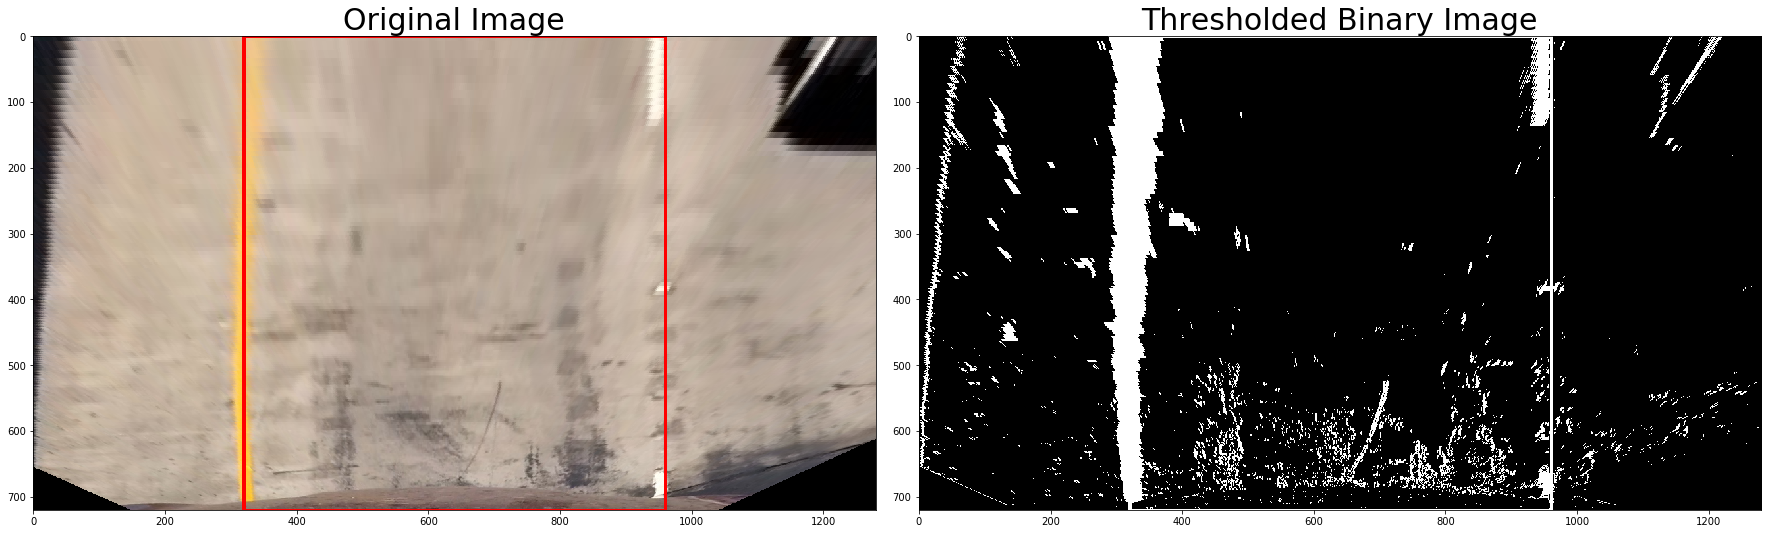

In [6]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Assumed given image is already in Gray
    # 1) Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    sobelx_abs = np.absolute(sobelx)
    sobely_abs = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    gradient_dir = np.arctan2(sobely_abs, sobelx_abs)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(gradient_dir)
    # 6) Return this mask as your binary_output image
    binary_output[(gradient_dir > thresh[0]) & (gradient_dir < thresh[1])] = 1
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):

    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def get_thresholded_binary_image(img, s_thresh=(80, 255), sx_thresh=(10, 80)):
    
    #def get_thresholded_binary_image(img, s_thresh=(100, 255), sx_thresh=(10, 70)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the S channel
    hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hsl[:,:,2]
    
    l_channel = hsl[:,:,1]
    
    #Calculate sobel gradient along x axis
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.float)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold S - color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold L - color channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= 120) & (l_channel <= 255)] = 1
    
    
    #dir_of_gradient
    #dir_of_grad = dir_threshold(gray, sobel_kernel=3, thresh=(np.pi/7, np.pi/2))
    
    #magnitude of the gradient
    #mag_binary = mag_thresh(gray, sobel_kernel=3, mag_thresh=(30, 100))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary == 1) | (sxbinary == 1)) & (l_binary == 1) ] = 1

    return combined_binary


thresholded_binary_image = get_thresholded_binary_image(warp_img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warp_img)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(thresholded_binary_image, cmap='gray')
ax2.set_title('Thresholded Binary Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 5. Identify lane-line pixels and fit their positions with a polynomial

Here I take the histogram of a binary warped image along the y-axis and take half of the histogram to detect left lane pixels and the remaining half to detect right lane pixels. Then use a sliding window to find the non-zero left and right indices of x and y of the detected lane pixels and from there fit the coordinates of x and y into a second order polynomial equation and return the left and right coefficients along with the detected non-zero indices.

In [7]:
#print(thresholded_binary_image.shape)

def detect_lane_lines (binary_warped, draw):
    
    # Take a histogram of the bottom half of the image
    # // divide with integer discard remainder
    histogram = np.sum(thresholded_binary_image[thresholded_binary_image.shape[0]//2:,:], axis=0)
    
    # this is for debugging, draw = 1 if we need to see how the lane detection goes  
    if draw == 1:
        plt.plot(histogram)

    #Create an white output image to draw on and visualize the result
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.array([0,0,0], dtype='float')
    right_fit = np.array([0,0,0], dtype='float')
    
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    return left_lane_inds, right_lane_inds, left_fit, right_fit


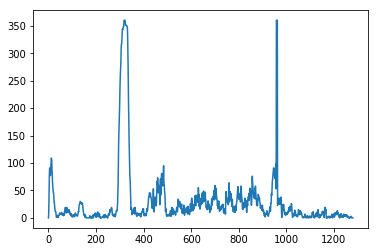

In [8]:
# now call the function to try the detection
left_lane_inds, right_lane_inds, left_fit, right_fit = detect_lane_lines(thresholded_binary_image, 1)

In [9]:
'''
 When the lanes are previously detected, this function can be used to find the left and right coefficients of the 
 fitted second order equation.
 
'''
def use_previous_detection (binary_img, l_fit, r_fit):
    
    nonzero = binary_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the width of the windows +/- margin
    margin = 50
    
    # Create empty lists to receive left and right lane pixel indices
    #left_lane_inds = []
    #right_lane_inds = []
    
    # find left indices based on previous left fit 
    left_lane_inds = ((nonzerox > (l_fit[0]*(nonzeroy**2) + l_fit[1]*nonzeroy + l_fit[2] - margin)) & 
                      (nonzerox < (l_fit[0]*(nonzeroy**2) + l_fit[1]*nonzeroy + l_fit[2] + margin))) 
    
    # find right indices based on previous right fit 
    right_lane_inds = ((nonzerox > (r_fit[0]*(nonzeroy**2) + r_fit[1]*nonzeroy + r_fit[2] - margin)) & 
                       (nonzerox < (r_fit[0]*(nonzeroy**2) + r_fit[1]*nonzeroy + r_fit[2] + margin)))
    
    # Now derive left and right line pixel positions based on the above indices
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit the second order polynomial for left and right lane based on above pixels
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        l_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        r_fit = np.polyfit(righty, rightx, 2)

    return left_lane_inds, right_lane_inds, l_fit, r_fit



Draw the line through the detected lane pixels using the above fitted coefficients(A, B and C) for left and
right fit.

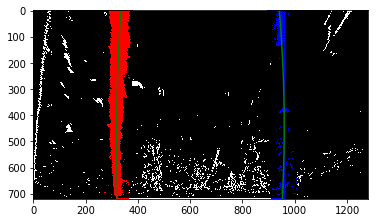

In [10]:
def draw_lanes_and_lines(binary_warped, left_lane_inds, right_lane_inds, left_fit, right_fit):
    
    # Create an image to draw on lane pixels and detected lines
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # draw the left lane pixels with red
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    # draw the right lane pixels with blue
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #draw the image
    plt.imshow(out_img)
    
    #draw the fitted lane lines
    plt.plot(left_fitx, ploty, color='green')
    plt.plot(right_fitx, ploty, color='green')
    
draw_lanes_and_lines(thresholded_binary_image, left_lane_inds, right_lane_inds, left_fit, right_fit)

# 6.  Calculated the radius of curvature of the lane and the position of the vehicle with respect to center. 
I use the following equation to find the radius of curvature for detected left and right lanes
f'(y)= dx/dy = 2Ay+B
f′′(y)= d2x/dy2 = 2A
and Radius of curve = ((1+(2Ay+B)**2)**1.5)/|2A|

Given the binary warped image, left and right indices of detected lanes and the left and right coefficients of the fitted lines, the corresponding x and y coordinates in pixel value were derived. Then use the conversion ratio (from pixel to meter) devive the fitted coefficients(A, B, C) again in meters and from there use the equation above to derive radius of curvature for left and right lane in meter. Aslo from bottom Ys (left and right of the image,close to car dashboard) find the Xs coordinate and derive the middle lane line. Then find the position of the vehicle by taking the absolute difference between the middle of image and the middle lane line above.
I also return the bottom left and right x-coordinate of the lanes to find the space between the lanes which will be used to correct the detection later on.
 

In [11]:
'''
   Calculated the radius of curvature of the lane and the position of the 
   vehicle with respect to center.
''' 

def find_radius_of_curvature(binary_warped, left_lane_inds, right_lane_inds, \
                             left_fit, right_fit):
    
    y_bottom = binary_warped.shape[0]
    
    # to cover same y-range as image
    ploty = np.linspace(0, y_bottom - 1, y_bottom)
    
    # maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
   
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    #leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    #rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to each, this is to draw
    # left and right lane through the detected lane pixels
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]

    '''
    # Plot the detected lanes (left and right)
    mark_size = 1
    plt.plot(leftx, lefty, 'o', color='red', markersize=mark_size)
    plt.plot(rightx, righty, 'o', color='blue', markersize=mark_size)
    #plt.xlim(0, 1280)
    #plt.ylim(0, 720)

    # Plot the fitted left and right line
    plt.plot(left_fitx, lefty, color='green', linewidth=1)
    plt.plot(right_fitx, righty, color='green', linewidth=1)
    '''
    
    left_curverad = 0
    right_curverad = 0
    left_fit_cr = np.array([0,0,0], dtype='float')
    right_fit_cr = np.array([0,0,0], dtype='float')

    # fit again with real dimention 
    if len(leftx) != 0:
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    
    if len(rightx) != 0:
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)


    # Calculate the new radii of curvature
    if len(left_fit_cr) != 0:
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + \
                        left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    
    if len(right_fit_cr) != 0:
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + \
                        right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Camera position (middle of the car) is middle of the image
    # along the x - axis
    camera_pos = binary_warped.shape[1]/2
    left_bottom_x = left_fit[0]*y_bottom**2 + left_fit[1]*y_bottom + left_fit[2]
    right_bottom_x = right_fit[0]*y_bottom**2 + right_fit[1]*y_bottom + right_fit[2]
    lane_center_pos = (left_bottom_x + right_bottom_x)/2
    camera_dis_from_center = (camera_pos - lane_center_pos)*xm_per_pix
        
    # radius of curvature, center distance is in meters
    return left_curverad, right_curverad, camera_dis_from_center, left_bottom_x, right_bottom_x


l_curved, r_curved, center_distance, l_bottom_x, r_bottom_x = find_radius_of_curvature(thresholded_binary_image, \
                                    left_lane_inds, right_lane_inds, left_fit, right_fit)

print(l_curved, 'm', r_curved, 'm', center_distance, 'center distance', 'bottom left x:', l_bottom_x, \
      'bottom right x:', r_bottom_x)



2443.54213985 m 1729.52437842 m 0.0139764059536 center distance bottom left x: 322.26743961 bottom right x: 952.444190569


## 7. Provide an example image of the result plotted back down onto the road such that the          lane area is identified clearly.

In [12]:
def draw_lines(original_img, warped, left_fit, right_fit, Minv):
    
    copy_orig_img = np.copy(original_img)
    
    y,x = warped.shape
    
    # Cover same y-range as image
    ploty = np.linspace(0, y-1, num=y)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective 
    # matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (x, y)) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(copy_orig_img, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    return result


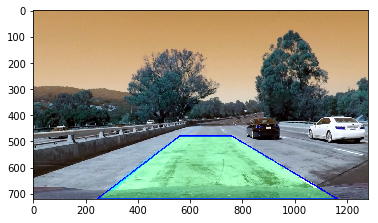

In [13]:
output = draw_lines(test_img, thresholded_binary_image, left_fit, right_fit, Minv)
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
plt.imshow(output)

Draw some usefull information such as left and right lane curvature, space between lanes etc.
This was visually observed to tune the detection and draw the lines.

In [14]:
def draw_text(img, l_curv, r_curv, center_distance, bottom_x_diff):
    font = cv2.FONT_HERSHEY_SIMPLEX
    text1 = 'Radius of Curvature: ' + 'left {:04.2f}'.format(l_curv) + 'm' \
                                    + ' Right {:04.2f}'.format(r_curv) + 'm'
    cv2.putText(img, text1,(40,70), font, 0.5 ,(255,255,255),2,cv2.LINE_AA)
    text2 = 'Center distance: ' + '{:04.2f}'.format(center_distance) + 'm ' + \
            'Lane separation: ' + '{:04.2f}'.format(bottom_x_diff) 
    cv2.putText(img, text2,(40,120), font, 0.5 ,(255,255,255),2,cv2.LINE_AA)
    return img
        

## 8. Pipeline to process the image.

Here for each frame (input) of the video first it undistorts the image, do a perspective transform ,
then apply color and gradient thresholds to create a binary image. This function also return the inverse perspective transform matrix which will be used to draw the lanes.

In [15]:
def pipeline(img):
    # Undistort
    undist_img = undistort(img)
    
    # Do a perspective Transform
    warp_img, M, Minv = warper(undist_img, src, dst)
    
    
    # Threshold HLS S-channel and x Gradient
    thresholded_binary_image = get_thresholded_binary_image(warp_img)
    
    return thresholded_binary_image, Minv


### Define a class to receive the characteristics of each line detection

In [16]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = np.array([0,0,0], dtype='float')
        
        #polynomial coefficients for the most recent fit
        self.current_fit = []

        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    
    '''
         Append the passed fit coefficient into last and calculate the 
         average fit_coefficient, store it in self.best_fit
    '''
    def add_fit(self, fit_coeff, lane_inds):
        self.current_fit.append(fit_coeff)
        self.best_fit = np.average(self.current_fit, axis=0)

    '''
        Remove the last fit coefficient from current fit and 
        average the remaining and store it in self.best_fit
    '''
    def rm_fit(self):
        no_of_fit = len(self.current_fit)
        if no_of_fit > 1:
            # remove the last fit.
            self.current_fit = self.current_fit[:no_of_fit - 1]
            self.best_fit = np.average(self.current_fit, axis=0)
            self.detected = False
    '''
        If there are more than 7 fit coefficients on current_fit
        remove the old one (the first one ), fifo/
        Average the remaining and store it in self.best_fit
    '''
    def update_fit(self, fit_coeff, lane_inds):

        if len(self.current_fit) > 7:
            self.current_fit  = self.current_fit[-5:]
        self.detected = True
        self.best_fit = np.average(self.current_fit, axis=0)
                    

In [17]:
def process_image(img):
    copy_img = np.copy(img)
    binary_img, Minv = pipeline(copy_img)
    
    if left_obj.detected is False or right_obj.detected is False:
        #print("Detecting lanes")
        left_lane_inds, right_lane_inds, left_fit, right_fit = \
                                                detect_lane_lines(binary_img, 0)
    else:
        print("Use previous detected lanes")
        left_lane_inds, right_lane_inds, left_fit, right_fit = \
                         use_previous_detection(binary_img, left_obj.best_fit, right_obj.best_fit)
    
   
    left_obj.add_fit(left_fit, left_lane_inds)
    right_obj.add_fit(right_fit, right_lane_inds)
    

    l_curved, r_curved, center_distance, l_bottom_x, r_bottom_x = find_radius_of_curvature( \
                                                binary_img, left_lane_inds, \
                                                right_lane_inds, left_obj.best_fit, \
                                                right_obj.best_fit)
    
    bottom_x_diff = abs(r_bottom_x - l_bottom_x)

    # 
    # Following need to be true for a valid detection,
    #  1. The space between both lanes need to be within 400 to 500 pixel.
    #  2. ratio of both curved need to be less than 1.5 (approximate ), roughly parallel 
    # curve ratio 1.3
    if 400 < bottom_x_diff <= 630:
        if (((l_curved > r_curved) and (l_curved/r_curved < 1.5)) or \
                                            ((r_curved > l_curved) and (r_curved/l_curved < 1.5))):
            
            # Good detection and keep using this fit coefficient for next frame processing
            left_obj.update_fit(left_fit, left_lane_inds)
            right_obj.update_fit(right_fit, right_lane_inds)
        else:
            #print("bad fit 1")
            # remove this fit coefficient and update the average 
            left_obj.rm_fit()
            right_obj.rm_fit()            
    else:
        #print("bad fit 2")
        # remove this fit coefficient and update the average
        left_obj.rm_fit()
        right_obj.rm_fit()
 
    if left_obj.best_fit is not None and right_obj.best_fit is not None:
        print("Drawing...")
        output = draw_lines(copy_img, binary_img, left_obj.best_fit, \
                            right_obj.best_fit, Minv)
        
        l_curved, r_curved, center_distance, l_bottom_x, r_bottom_x = find_radius_of_curvature( \
                                                binary_img, left_lane_inds, \
                                                right_lane_inds, left_obj.best_fit, \
                                                right_obj.best_fit)
        bottom_x_diff = abs(r_bottom_x - l_bottom_x)
        output = draw_text(output, l_curved, r_curved, center_distance, bottom_x_diff)
    else:
        output = copy_img

    return output

In [18]:

left_obj = Line()
right_obj = Line()

video_output1 = '../output_images/project_video_output.mp4'
video_input1 = VideoFileClip('../project_video.mp4') #.subclip(0, 2)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)


Drawing...
[MoviePy] >>>> Building video ../output_images/project_video_output.mp4
[MoviePy] Writing video ../output_images/project_video_output.mp4


  0%|          | 1/1261 [00:00<02:55,  7.17it/s]

Drawing...


  0%|          | 2/1261 [00:00<02:54,  7.21it/s]

Drawing...


  0%|          | 3/1261 [00:00<02:59,  7.01it/s]

Drawing...


  0%|          | 4/1261 [00:00<02:58,  7.03it/s]

Use previous detected lanes
Drawing...


  0%|          | 5/1261 [00:00<02:57,  7.08it/s]

Drawing...


  0%|          | 6/1261 [00:00<02:57,  7.07it/s]

Drawing...


  1%|          | 7/1261 [00:00<02:57,  7.05it/s]

Drawing...


  1%|          | 8/1261 [00:01<02:56,  7.11it/s]

Drawing...


  1%|          | 9/1261 [00:01<02:54,  7.18it/s]

Drawing...


  1%|          | 10/1261 [00:01<02:53,  7.20it/s]

Use previous detected lanes
Drawing...


  1%|          | 11/1261 [00:01<02:56,  7.10it/s]

Drawing...


  1%|          | 12/1261 [00:01<02:55,  7.10it/s]

Drawing...


  1%|          | 13/1261 [00:01<02:55,  7.11it/s]

Drawing...


  1%|          | 14/1261 [00:01<02:53,  7.18it/s]

Drawing...


  1%|          | 15/1261 [00:02<02:53,  7.20it/s]

Use previous detected lanes
Drawing...


  1%|▏         | 16/1261 [00:02<02:53,  7.16it/s]

Use previous detected lanes
Drawing...


  1%|▏         | 17/1261 [00:02<02:52,  7.21it/s]

Drawing...


  1%|▏         | 18/1261 [00:02<02:53,  7.17it/s]

Drawing...


  2%|▏         | 19/1261 [00:02<02:54,  7.11it/s]

Drawing...


  2%|▏         | 20/1261 [00:02<02:53,  7.14it/s]

Drawing...


  2%|▏         | 21/1261 [00:02<02:53,  7.13it/s]

Drawing...


  2%|▏         | 22/1261 [00:03<02:54,  7.09it/s]

Drawing...


  2%|▏         | 23/1261 [00:03<02:54,  7.10it/s]

Use previous detected lanes
Drawing...


  2%|▏         | 24/1261 [00:03<02:55,  7.05it/s]

Drawing...


  2%|▏         | 25/1261 [00:03<02:54,  7.10it/s]

Use previous detected lanes
Drawing...


  2%|▏         | 26/1261 [00:03<02:53,  7.12it/s]

Use previous detected lanes
Drawing...


  2%|▏         | 27/1261 [00:03<02:53,  7.11it/s]

Drawing...


  2%|▏         | 28/1261 [00:03<02:52,  7.16it/s]

Drawing...


  2%|▏         | 29/1261 [00:04<02:52,  7.16it/s]

Drawing...


  2%|▏         | 30/1261 [00:04<02:52,  7.14it/s]

Drawing...


  2%|▏         | 31/1261 [00:04<02:52,  7.12it/s]

Drawing...


  3%|▎         | 32/1261 [00:04<02:51,  7.15it/s]

Use previous detected lanes
Drawing...


  3%|▎         | 33/1261 [00:04<02:51,  7.15it/s]

Drawing...


  3%|▎         | 34/1261 [00:04<02:52,  7.12it/s]

Drawing...


  3%|▎         | 35/1261 [00:04<02:51,  7.16it/s]

Drawing...


  3%|▎         | 36/1261 [00:05<02:53,  7.08it/s]

Drawing...


  3%|▎         | 37/1261 [00:05<02:53,  7.04it/s]

Drawing...


  3%|▎         | 38/1261 [00:05<02:51,  7.15it/s]

Drawing...


  3%|▎         | 39/1261 [00:05<02:52,  7.07it/s]

Drawing...


  3%|▎         | 40/1261 [00:05<02:49,  7.20it/s]

Use previous detected lanes
Drawing...


  3%|▎         | 41/1261 [00:05<02:49,  7.21it/s]

Use previous detected lanes
Drawing...


  3%|▎         | 42/1261 [00:05<02:52,  7.07it/s]

Drawing...


  3%|▎         | 43/1261 [00:06<02:52,  7.04it/s]

Drawing...


  3%|▎         | 44/1261 [00:06<02:51,  7.09it/s]

Drawing...


  4%|▎         | 45/1261 [00:06<02:49,  7.15it/s]

Drawing...


  4%|▎         | 46/1261 [00:06<02:50,  7.11it/s]

Drawing...


  4%|▎         | 47/1261 [00:06<02:48,  7.18it/s]

Drawing...


  4%|▍         | 48/1261 [00:06<02:49,  7.16it/s]

Drawing...


  4%|▍         | 49/1261 [00:06<02:49,  7.16it/s]

Drawing...


  4%|▍         | 50/1261 [00:07<02:50,  7.12it/s]

Drawing...


  4%|▍         | 51/1261 [00:07<02:48,  7.19it/s]

Drawing...


  4%|▍         | 52/1261 [00:07<02:48,  7.18it/s]

Use previous detected lanes
Drawing...


  4%|▍         | 53/1261 [00:07<02:47,  7.20it/s]

Use previous detected lanes
Drawing...


  4%|▍         | 54/1261 [00:07<02:47,  7.21it/s]

Use previous detected lanes
Drawing...


  4%|▍         | 55/1261 [00:07<02:47,  7.20it/s]

Use previous detected lanes
Drawing...


  4%|▍         | 56/1261 [00:07<02:46,  7.22it/s]

Use previous detected lanes
Drawing...


  5%|▍         | 57/1261 [00:07<02:46,  7.22it/s]

Drawing...


  5%|▍         | 58/1261 [00:08<02:47,  7.19it/s]

Use previous detected lanes
Drawing...


  5%|▍         | 59/1261 [00:08<02:49,  7.09it/s]

Use previous detected lanes
Drawing...


  5%|▍         | 60/1261 [00:08<02:50,  7.03it/s]

Drawing...


  5%|▍         | 61/1261 [00:08<02:47,  7.15it/s]

Use previous detected lanes
Drawing...


  5%|▍         | 62/1261 [00:08<02:48,  7.12it/s]

Drawing...


  5%|▍         | 63/1261 [00:08<02:47,  7.13it/s]

Drawing...


  5%|▌         | 64/1261 [00:08<02:49,  7.06it/s]

Drawing...


  5%|▌         | 65/1261 [00:09<02:47,  7.14it/s]

Drawing...


  5%|▌         | 66/1261 [00:09<02:50,  7.02it/s]

Drawing...


  5%|▌         | 67/1261 [00:09<02:50,  7.01it/s]

Drawing...


  5%|▌         | 68/1261 [00:09<02:50,  7.01it/s]

Drawing...


  5%|▌         | 69/1261 [00:09<02:49,  7.05it/s]

Use previous detected lanes
Drawing...


  6%|▌         | 70/1261 [00:09<02:48,  7.06it/s]

Drawing...


  6%|▌         | 71/1261 [00:09<02:47,  7.12it/s]

Drawing...


  6%|▌         | 72/1261 [00:10<02:56,  6.74it/s]

Drawing...
Drawing...


  6%|▌         | 74/1261 [00:10<03:02,  6.52it/s]

Drawing...


  6%|▌         | 75/1261 [00:10<02:57,  6.69it/s]

Drawing...


  6%|▌         | 76/1261 [00:10<02:56,  6.72it/s]

Drawing...


  6%|▌         | 77/1261 [00:10<02:53,  6.81it/s]

Use previous detected lanes
Drawing...


  6%|▌         | 78/1261 [00:11<02:52,  6.86it/s]

Drawing...


  6%|▋         | 79/1261 [00:11<02:50,  6.92it/s]

Use previous detected lanes
Drawing...


  6%|▋         | 80/1261 [00:11<02:51,  6.90it/s]

Drawing...


  6%|▋         | 81/1261 [00:11<02:52,  6.83it/s]

Drawing...


  7%|▋         | 82/1261 [00:11<02:55,  6.72it/s]

Drawing...


  7%|▋         | 83/1261 [00:11<02:54,  6.75it/s]

Drawing...


  7%|▋         | 84/1261 [00:11<02:53,  6.79it/s]

Drawing...


  7%|▋         | 85/1261 [00:12<02:50,  6.90it/s]

Drawing...


  7%|▋         | 86/1261 [00:12<02:50,  6.88it/s]

Use previous detected lanes
Drawing...


  7%|▋         | 87/1261 [00:12<02:50,  6.87it/s]

Drawing...


  7%|▋         | 88/1261 [00:12<02:49,  6.94it/s]

Drawing...


  7%|▋         | 89/1261 [00:12<02:47,  6.99it/s]

Drawing...


  7%|▋         | 90/1261 [00:12<02:48,  6.93it/s]

Drawing...


  7%|▋         | 91/1261 [00:12<02:52,  6.78it/s]

Drawing...


  7%|▋         | 92/1261 [00:13<02:51,  6.81it/s]

Drawing...


  7%|▋         | 93/1261 [00:13<02:50,  6.85it/s]

Use previous detected lanes
Drawing...


  7%|▋         | 94/1261 [00:13<02:49,  6.90it/s]

Drawing...


  8%|▊         | 95/1261 [00:13<02:48,  6.92it/s]

Drawing...


  8%|▊         | 96/1261 [00:13<02:47,  6.94it/s]

Drawing...


  8%|▊         | 97/1261 [00:13<02:49,  6.88it/s]

Drawing...


  8%|▊         | 98/1261 [00:13<02:47,  6.95it/s]

Drawing...


  8%|▊         | 99/1261 [00:14<02:46,  6.96it/s]

Drawing...


  8%|▊         | 100/1261 [00:14<02:46,  6.96it/s]

Drawing...


  8%|▊         | 101/1261 [00:14<02:46,  6.97it/s]

Drawing...


  8%|▊         | 102/1261 [00:14<02:46,  6.98it/s]

Drawing...


  8%|▊         | 103/1261 [00:14<02:46,  6.97it/s]

Use previous detected lanes
Drawing...


  8%|▊         | 104/1261 [00:14<02:46,  6.96it/s]

Drawing...


  8%|▊         | 105/1261 [00:14<02:47,  6.91it/s]

Drawing...


  8%|▊         | 106/1261 [00:15<02:46,  6.93it/s]

Use previous detected lanes
Drawing...


  8%|▊         | 107/1261 [00:15<02:46,  6.94it/s]

Use previous detected lanes
Drawing...


  9%|▊         | 108/1261 [00:15<02:45,  6.98it/s]

Use previous detected lanes
Drawing...


  9%|▊         | 109/1261 [00:15<02:46,  6.93it/s]

Use previous detected lanes
Drawing...


  9%|▊         | 110/1261 [00:15<02:47,  6.86it/s]

Use previous detected lanes
Drawing...


  9%|▉         | 111/1261 [00:15<02:48,  6.84it/s]

Use previous detected lanes
Drawing...


  9%|▉         | 112/1261 [00:15<02:48,  6.82it/s]

Drawing...


  9%|▉         | 113/1261 [00:16<02:45,  6.93it/s]

Drawing...


  9%|▉         | 114/1261 [00:16<02:44,  6.97it/s]

Drawing...


  9%|▉         | 115/1261 [00:16<02:43,  6.99it/s]

Drawing...


  9%|▉         | 116/1261 [00:16<02:45,  6.94it/s]

Use previous detected lanes
Drawing...


  9%|▉         | 117/1261 [00:16<02:44,  6.95it/s]

Use previous detected lanes
Drawing...


  9%|▉         | 118/1261 [00:16<02:44,  6.95it/s]

Use previous detected lanes
Drawing...


  9%|▉         | 119/1261 [00:16<02:44,  6.96it/s]

Drawing...


 10%|▉         | 120/1261 [00:17<02:44,  6.93it/s]

Drawing...


 10%|▉         | 121/1261 [00:17<02:46,  6.85it/s]

Drawing...


 10%|▉         | 122/1261 [00:17<02:47,  6.78it/s]

Drawing...


 10%|▉         | 123/1261 [00:17<02:46,  6.84it/s]

Use previous detected lanes
Drawing...


 10%|▉         | 124/1261 [00:17<02:46,  6.81it/s]

Use previous detected lanes
Drawing...


 10%|▉         | 125/1261 [00:17<02:45,  6.85it/s]

Use previous detected lanes
Drawing...


 10%|▉         | 126/1261 [00:17<02:44,  6.88it/s]

Use previous detected lanes
Drawing...


 10%|█         | 127/1261 [00:18<02:44,  6.88it/s]

Drawing...


 10%|█         | 128/1261 [00:18<02:43,  6.94it/s]

Drawing...


 10%|█         | 129/1261 [00:18<02:43,  6.93it/s]

Use previous detected lanes
Drawing...


 10%|█         | 130/1261 [00:18<02:43,  6.90it/s]

Use previous detected lanes
Drawing...


 10%|█         | 131/1261 [00:18<02:42,  6.95it/s]

Use previous detected lanes
Drawing...


 10%|█         | 132/1261 [00:18<02:42,  6.96it/s]

Use previous detected lanes
Drawing...


 11%|█         | 133/1261 [00:18<02:41,  6.98it/s]

Use previous detected lanes
Drawing...


 11%|█         | 134/1261 [00:19<02:41,  6.96it/s]

Drawing...


 11%|█         | 135/1261 [00:19<02:40,  7.00it/s]

Use previous detected lanes
Drawing...


 11%|█         | 136/1261 [00:19<02:43,  6.90it/s]

Use previous detected lanes
Drawing...


 11%|█         | 137/1261 [00:19<02:42,  6.92it/s]

Use previous detected lanes
Drawing...


 11%|█         | 138/1261 [00:19<02:41,  6.95it/s]

Use previous detected lanes
Drawing...


 11%|█         | 139/1261 [00:19<02:43,  6.87it/s]

Drawing...


 11%|█         | 140/1261 [00:20<02:39,  7.01it/s]

Use previous detected lanes
Drawing...


 11%|█         | 141/1261 [00:20<02:41,  6.94it/s]

Drawing...


 11%|█▏        | 142/1261 [00:20<02:40,  6.98it/s]

Use previous detected lanes
Drawing...


 11%|█▏        | 143/1261 [00:20<02:40,  6.95it/s]

Drawing...


 11%|█▏        | 144/1261 [00:20<02:40,  6.95it/s]

Use previous detected lanes
Drawing...


 11%|█▏        | 145/1261 [00:20<02:41,  6.92it/s]

Use previous detected lanes
Drawing...


 12%|█▏        | 146/1261 [00:20<02:40,  6.95it/s]

Use previous detected lanes
Drawing...


 12%|█▏        | 147/1261 [00:21<02:40,  6.96it/s]

Use previous detected lanes
Drawing...


 12%|█▏        | 148/1261 [00:21<02:38,  7.00it/s]

Use previous detected lanes
Drawing...


 12%|█▏        | 149/1261 [00:21<02:38,  7.01it/s]

Drawing...


 12%|█▏        | 150/1261 [00:21<02:38,  7.03it/s]

Drawing...


 12%|█▏        | 151/1261 [00:21<02:38,  7.01it/s]

Drawing...


 12%|█▏        | 152/1261 [00:21<02:37,  7.03it/s]

Use previous detected lanes
Drawing...


 12%|█▏        | 153/1261 [00:21<02:39,  6.95it/s]

Drawing...


 12%|█▏        | 154/1261 [00:22<02:37,  7.04it/s]

Use previous detected lanes
Drawing...


 12%|█▏        | 155/1261 [00:22<02:38,  6.98it/s]

Use previous detected lanes
Drawing...


 12%|█▏        | 156/1261 [00:22<02:38,  6.98it/s]

Use previous detected lanes
Drawing...


 12%|█▏        | 157/1261 [00:22<02:37,  7.00it/s]

Use previous detected lanes
Drawing...


 13%|█▎        | 158/1261 [00:22<02:38,  6.96it/s]

Use previous detected lanes
Drawing...


 13%|█▎        | 159/1261 [00:22<02:37,  6.99it/s]

Use previous detected lanes
Drawing...


 13%|█▎        | 160/1261 [00:22<02:37,  6.98it/s]

Drawing...


 13%|█▎        | 161/1261 [00:23<02:35,  7.05it/s]

Use previous detected lanes
Drawing...


 13%|█▎        | 162/1261 [00:23<02:38,  6.93it/s]

Use previous detected lanes
Drawing...


 13%|█▎        | 163/1261 [00:23<02:38,  6.93it/s]

Use previous detected lanes
Drawing...


 13%|█▎        | 164/1261 [00:23<02:37,  6.98it/s]

Use previous detected lanes
Drawing...


 13%|█▎        | 165/1261 [00:23<02:37,  6.97it/s]

Drawing...


 13%|█▎        | 166/1261 [00:23<02:37,  6.96it/s]

Drawing...


 13%|█▎        | 167/1261 [00:23<02:36,  6.99it/s]

Drawing...


 13%|█▎        | 168/1261 [00:24<02:37,  6.93it/s]

Drawing...


 13%|█▎        | 169/1261 [00:24<02:36,  6.96it/s]

Drawing...


 13%|█▎        | 170/1261 [00:24<02:37,  6.95it/s]

Drawing...


 14%|█▎        | 171/1261 [00:24<02:35,  7.01it/s]

Drawing...


 14%|█▎        | 172/1261 [00:24<02:36,  6.97it/s]

Drawing...


 14%|█▎        | 173/1261 [00:24<02:34,  7.05it/s]

Drawing...


 14%|█▍        | 174/1261 [00:24<02:34,  7.02it/s]

Drawing...


 14%|█▍        | 175/1261 [00:25<02:34,  7.05it/s]

Drawing...


 14%|█▍        | 176/1261 [00:25<02:36,  6.95it/s]

Drawing...


 14%|█▍        | 177/1261 [00:25<02:34,  7.02it/s]

Drawing...


 14%|█▍        | 178/1261 [00:25<02:34,  7.01it/s]

Drawing...


 14%|█▍        | 179/1261 [00:25<02:35,  6.95it/s]

Drawing...


 14%|█▍        | 180/1261 [00:25<02:35,  6.94it/s]

Drawing...


 14%|█▍        | 181/1261 [00:25<02:35,  6.93it/s]

Drawing...


 14%|█▍        | 182/1261 [00:26<02:36,  6.89it/s]

Drawing...


 15%|█▍        | 183/1261 [00:26<02:36,  6.88it/s]

Drawing...


 15%|█▍        | 184/1261 [00:26<02:35,  6.91it/s]

Drawing...


 15%|█▍        | 185/1261 [00:26<02:36,  6.89it/s]

Drawing...


 15%|█▍        | 186/1261 [00:26<02:34,  6.96it/s]

Drawing...


 15%|█▍        | 187/1261 [00:26<02:34,  6.96it/s]

Drawing...


 15%|█▍        | 188/1261 [00:26<02:33,  6.99it/s]

Drawing...


 15%|█▍        | 189/1261 [00:27<02:33,  6.99it/s]

Drawing...


 15%|█▌        | 190/1261 [00:27<02:32,  7.01it/s]

Drawing...


 15%|█▌        | 191/1261 [00:27<02:32,  7.01it/s]

Drawing...


 15%|█▌        | 192/1261 [00:27<02:33,  6.94it/s]

Drawing...


 15%|█▌        | 193/1261 [00:27<02:34,  6.93it/s]

Drawing...


 15%|█▌        | 194/1261 [00:27<02:31,  7.04it/s]

Drawing...


 15%|█▌        | 195/1261 [00:27<02:32,  6.98it/s]

Drawing...


 16%|█▌        | 196/1261 [00:28<02:32,  6.98it/s]

Use previous detected lanes
Drawing...


 16%|█▌        | 197/1261 [00:28<02:32,  6.97it/s]

Drawing...


 16%|█▌        | 198/1261 [00:28<02:31,  6.99it/s]

Drawing...


 16%|█▌        | 199/1261 [00:28<02:32,  6.98it/s]

Drawing...


 16%|█▌        | 200/1261 [00:28<02:32,  6.94it/s]

Drawing...


 16%|█▌        | 201/1261 [00:28<02:33,  6.92it/s]

Drawing...


 16%|█▌        | 202/1261 [00:28<02:34,  6.86it/s]

Drawing...


 16%|█▌        | 203/1261 [00:29<02:35,  6.79it/s]

Drawing...


 16%|█▌        | 204/1261 [00:29<02:36,  6.77it/s]

Drawing...


 16%|█▋        | 205/1261 [00:29<02:36,  6.73it/s]

Drawing...


 16%|█▋        | 206/1261 [00:29<02:37,  6.70it/s]

Drawing...


 16%|█▋        | 207/1261 [00:29<02:37,  6.70it/s]

Drawing...


 16%|█▋        | 208/1261 [00:29<02:35,  6.76it/s]

Drawing...


 17%|█▋        | 209/1261 [00:29<02:33,  6.87it/s]

Drawing...


 17%|█▋        | 210/1261 [00:30<02:31,  6.91it/s]

Drawing...


 17%|█▋        | 211/1261 [00:30<02:31,  6.94it/s]

Drawing...


 17%|█▋        | 212/1261 [00:30<02:30,  6.97it/s]

Drawing...


 17%|█▋        | 213/1261 [00:30<02:29,  7.01it/s]

Drawing...


 17%|█▋        | 214/1261 [00:30<02:32,  6.88it/s]

Drawing...


 17%|█▋        | 215/1261 [00:30<02:30,  6.95it/s]

Drawing...


 17%|█▋        | 216/1261 [00:30<02:30,  6.94it/s]

Drawing...


 17%|█▋        | 217/1261 [00:31<02:31,  6.90it/s]

Drawing...


 17%|█▋        | 218/1261 [00:31<02:30,  6.94it/s]

Drawing...


 17%|█▋        | 219/1261 [00:31<02:30,  6.92it/s]

Drawing...


 17%|█▋        | 220/1261 [00:31<02:29,  6.96it/s]

Drawing...


 18%|█▊        | 221/1261 [00:31<02:28,  7.00it/s]

Drawing...


 18%|█▊        | 222/1261 [00:31<02:28,  7.02it/s]

Drawing...


 18%|█▊        | 223/1261 [00:31<02:28,  7.01it/s]

Drawing...


 18%|█▊        | 224/1261 [00:32<02:28,  6.96it/s]

Drawing...


 18%|█▊        | 225/1261 [00:32<02:27,  7.02it/s]

Drawing...


 18%|█▊        | 226/1261 [00:32<02:29,  6.92it/s]

Drawing...


 18%|█▊        | 227/1261 [00:32<02:28,  6.97it/s]

Drawing...


 18%|█▊        | 228/1261 [00:32<02:28,  6.97it/s]

Drawing...


 18%|█▊        | 229/1261 [00:32<02:28,  6.97it/s]

Drawing...


 18%|█▊        | 230/1261 [00:32<02:29,  6.89it/s]

Drawing...


 18%|█▊        | 231/1261 [00:33<02:28,  6.92it/s]

Drawing...


 18%|█▊        | 232/1261 [00:33<02:28,  6.94it/s]

Drawing...


 18%|█▊        | 233/1261 [00:33<02:27,  6.99it/s]

Drawing...


 19%|█▊        | 234/1261 [00:33<02:26,  6.99it/s]

Drawing...


 19%|█▊        | 235/1261 [00:33<02:25,  7.03it/s]

Drawing...


 19%|█▊        | 236/1261 [00:33<02:25,  7.04it/s]

Drawing...


 19%|█▉        | 237/1261 [00:33<02:24,  7.09it/s]

Drawing...


 19%|█▉        | 238/1261 [00:34<02:24,  7.06it/s]

Drawing...


 19%|█▉        | 239/1261 [00:34<02:24,  7.08it/s]

Drawing...


 19%|█▉        | 240/1261 [00:34<02:24,  7.06it/s]

Drawing...


 19%|█▉        | 241/1261 [00:34<02:24,  7.08it/s]

Drawing...


 19%|█▉        | 242/1261 [00:34<02:25,  7.02it/s]

Drawing...


 19%|█▉        | 243/1261 [00:34<02:25,  7.00it/s]

Drawing...


 19%|█▉        | 244/1261 [00:34<02:25,  6.98it/s]

Drawing...


 19%|█▉        | 245/1261 [00:35<02:25,  6.99it/s]

Drawing...


 20%|█▉        | 246/1261 [00:35<02:23,  7.05it/s]

Drawing...


 20%|█▉        | 247/1261 [00:35<02:23,  7.04it/s]

Drawing...


 20%|█▉        | 248/1261 [00:35<02:23,  7.05it/s]

Drawing...


 20%|█▉        | 249/1261 [00:35<02:24,  7.01it/s]

Drawing...


 20%|█▉        | 250/1261 [00:35<02:23,  7.04it/s]

Drawing...


 20%|█▉        | 251/1261 [00:35<02:24,  7.00it/s]

Drawing...


 20%|█▉        | 252/1261 [00:36<02:22,  7.07it/s]

Drawing...


 20%|██        | 253/1261 [00:36<02:23,  7.01it/s]

Drawing...


 20%|██        | 254/1261 [00:36<02:25,  6.91it/s]

Drawing...


 20%|██        | 255/1261 [00:36<02:26,  6.89it/s]

Drawing...


 20%|██        | 256/1261 [00:36<02:25,  6.92it/s]

Drawing...


 20%|██        | 257/1261 [00:36<02:24,  6.94it/s]

Drawing...


 20%|██        | 258/1261 [00:36<02:24,  6.95it/s]

Drawing...


 21%|██        | 259/1261 [00:37<02:23,  6.96it/s]

Drawing...


 21%|██        | 260/1261 [00:37<02:24,  6.94it/s]

Drawing...


 21%|██        | 261/1261 [00:37<02:22,  7.00it/s]

Drawing...


 21%|██        | 262/1261 [00:37<02:24,  6.91it/s]

Drawing...


 21%|██        | 263/1261 [00:37<02:23,  6.97it/s]

Drawing...


 21%|██        | 264/1261 [00:37<02:23,  6.94it/s]

Drawing...


 21%|██        | 265/1261 [00:37<02:22,  6.98it/s]

Drawing...


 21%|██        | 266/1261 [00:38<02:22,  6.96it/s]

Drawing...


 21%|██        | 267/1261 [00:38<02:22,  6.98it/s]

Drawing...


 21%|██▏       | 268/1261 [00:38<02:23,  6.93it/s]

Drawing...


 21%|██▏       | 269/1261 [00:38<02:23,  6.91it/s]

Drawing...


 21%|██▏       | 270/1261 [00:38<02:22,  6.96it/s]

Drawing...


 21%|██▏       | 271/1261 [00:38<02:23,  6.88it/s]

Drawing...


 22%|██▏       | 272/1261 [00:38<02:22,  6.96it/s]

Drawing...


 22%|██▏       | 273/1261 [00:39<02:23,  6.89it/s]

Drawing...


 22%|██▏       | 274/1261 [00:39<02:22,  6.94it/s]

Drawing...


 22%|██▏       | 275/1261 [00:39<02:22,  6.94it/s]

Drawing...


 22%|██▏       | 276/1261 [00:39<02:22,  6.93it/s]

Drawing...


 22%|██▏       | 277/1261 [00:39<02:22,  6.93it/s]

Drawing...


 22%|██▏       | 278/1261 [00:39<02:23,  6.86it/s]

Drawing...


 22%|██▏       | 279/1261 [00:39<02:22,  6.89it/s]

Drawing...


 22%|██▏       | 280/1261 [00:40<02:21,  6.94it/s]

Drawing...


 22%|██▏       | 281/1261 [00:40<02:21,  6.92it/s]

Drawing...


 22%|██▏       | 282/1261 [00:40<02:20,  6.95it/s]

Drawing...


 22%|██▏       | 283/1261 [00:40<02:20,  6.97it/s]

Drawing...


 23%|██▎       | 284/1261 [00:40<02:20,  6.95it/s]

Drawing...


 23%|██▎       | 285/1261 [00:40<02:21,  6.87it/s]

Drawing...


 23%|██▎       | 286/1261 [00:40<02:21,  6.91it/s]

Drawing...


 23%|██▎       | 287/1261 [00:41<02:20,  6.93it/s]

Drawing...


 23%|██▎       | 288/1261 [00:41<02:20,  6.92it/s]

Drawing...


 23%|██▎       | 289/1261 [00:41<02:20,  6.94it/s]

Drawing...


 23%|██▎       | 290/1261 [00:41<02:21,  6.88it/s]

Drawing...


 23%|██▎       | 291/1261 [00:41<02:22,  6.83it/s]

Drawing...


 23%|██▎       | 292/1261 [00:41<02:21,  6.86it/s]

Drawing...


 23%|██▎       | 293/1261 [00:42<02:21,  6.83it/s]

Drawing...


 23%|██▎       | 294/1261 [00:42<02:19,  6.92it/s]

Drawing...


 23%|██▎       | 295/1261 [00:42<02:18,  6.96it/s]

Drawing...


 23%|██▎       | 296/1261 [00:42<02:19,  6.93it/s]

Drawing...


 24%|██▎       | 297/1261 [00:42<02:19,  6.89it/s]

Drawing...


 24%|██▎       | 298/1261 [00:42<02:21,  6.79it/s]

Drawing...


 24%|██▎       | 299/1261 [00:42<02:24,  6.66it/s]

Drawing...


 24%|██▍       | 300/1261 [00:43<02:24,  6.67it/s]

Drawing...


 24%|██▍       | 301/1261 [00:43<02:25,  6.62it/s]

Drawing...
Drawing...


 24%|██▍       | 302/1261 [00:43<02:35,  6.17it/s]

Drawing...


 24%|██▍       | 303/1261 [00:43<02:41,  5.93it/s]

Drawing...


 24%|██▍       | 304/1261 [00:43<02:45,  5.80it/s]

Drawing...


 24%|██▍       | 305/1261 [00:43<02:45,  5.79it/s]

Drawing...


 24%|██▍       | 306/1261 [00:44<02:47,  5.72it/s]

Drawing...


 24%|██▍       | 307/1261 [00:44<02:49,  5.64it/s]

Drawing...


 24%|██▍       | 308/1261 [00:44<02:50,  5.59it/s]

Drawing...


 25%|██▍       | 309/1261 [00:44<02:50,  5.57it/s]

Drawing...


 25%|██▍       | 310/1261 [00:44<02:51,  5.53it/s]

Drawing...


 25%|██▍       | 312/1261 [00:45<02:41,  5.88it/s]

Drawing...


 25%|██▍       | 313/1261 [00:45<02:37,  6.00it/s]

Drawing...
Drawing...


 25%|██▍       | 315/1261 [00:45<02:37,  6.00it/s]

Drawing...
Drawing...


 25%|██▌       | 316/1261 [00:45<02:40,  5.88it/s]

Drawing...


 25%|██▌       | 317/1261 [00:46<02:45,  5.71it/s]

Drawing...


 25%|██▌       | 318/1261 [00:46<02:45,  5.69it/s]

Drawing...


 25%|██▌       | 319/1261 [00:46<02:45,  5.69it/s]

Drawing...


 25%|██▌       | 320/1261 [00:46<02:44,  5.73it/s]

Drawing...


 25%|██▌       | 321/1261 [00:46<02:45,  5.68it/s]

Drawing...


 26%|██▌       | 322/1261 [00:46<02:46,  5.65it/s]

Drawing...


 26%|██▌       | 323/1261 [00:47<02:47,  5.61it/s]

Drawing...


 26%|██▌       | 324/1261 [00:47<02:47,  5.59it/s]

Drawing...


 26%|██▌       | 325/1261 [00:47<02:46,  5.63it/s]

Drawing...


 26%|██▌       | 326/1261 [00:47<02:47,  5.57it/s]

Drawing...


 26%|██▌       | 327/1261 [00:47<02:47,  5.57it/s]

Drawing...


 26%|██▌       | 329/1261 [00:48<02:36,  5.94it/s]

Drawing...
Drawing...


 26%|██▌       | 330/1261 [00:48<02:39,  5.82it/s]

Drawing...


 26%|██▌       | 331/1261 [00:48<02:39,  5.83it/s]

Drawing...


 26%|██▋       | 332/1261 [00:48<02:41,  5.74it/s]

Drawing...


 26%|██▋       | 334/1261 [00:48<02:37,  5.88it/s]

Drawing...


 27%|██▋       | 335/1261 [00:49<02:32,  6.08it/s]

Drawing...


 27%|██▋       | 336/1261 [00:49<02:27,  6.28it/s]

Drawing...
Drawing...


 27%|██▋       | 337/1261 [00:49<02:34,  5.99it/s]

Drawing...


 27%|██▋       | 338/1261 [00:49<02:38,  5.84it/s]

Drawing...


 27%|██▋       | 339/1261 [00:49<02:41,  5.70it/s]

Drawing...


 27%|██▋       | 341/1261 [00:50<02:33,  6.00it/s]

Drawing...


 27%|██▋       | 342/1261 [00:50<02:28,  6.18it/s]

Drawing...


 27%|██▋       | 343/1261 [00:50<02:25,  6.32it/s]

Drawing...


 27%|██▋       | 344/1261 [00:50<02:21,  6.49it/s]

Drawing...


 27%|██▋       | 345/1261 [00:50<02:18,  6.62it/s]

Drawing...


 27%|██▋       | 346/1261 [00:50<02:16,  6.69it/s]

Drawing...


 28%|██▊       | 347/1261 [00:51<02:13,  6.83it/s]

Drawing...


 28%|██▊       | 348/1261 [00:51<02:13,  6.86it/s]

Drawing...


 28%|██▊       | 349/1261 [00:51<02:11,  6.93it/s]

Drawing...


 28%|██▊       | 350/1261 [00:51<02:11,  6.93it/s]

Use previous detected lanes
Drawing...


 28%|██▊       | 351/1261 [00:51<02:13,  6.83it/s]

Use previous detected lanes
Drawing...


 28%|██▊       | 352/1261 [00:51<02:12,  6.88it/s]

Drawing...


 28%|██▊       | 353/1261 [00:51<02:17,  6.59it/s]

Drawing...


 28%|██▊       | 354/1261 [00:52<02:15,  6.69it/s]

Drawing...


 28%|██▊       | 355/1261 [00:52<02:17,  6.57it/s]

Drawing...
Drawing...


 28%|██▊       | 356/1261 [00:52<02:24,  6.26it/s]

Drawing...


 28%|██▊       | 358/1261 [00:52<02:26,  6.17it/s]

Drawing...
Drawing...


 28%|██▊       | 359/1261 [00:52<02:28,  6.08it/s]

Drawing...


 29%|██▊       | 360/1261 [00:53<02:29,  6.04it/s]

Drawing...


 29%|██▊       | 361/1261 [00:53<02:33,  5.88it/s]

Drawing...


 29%|██▊       | 362/1261 [00:53<02:33,  5.84it/s]

Drawing...


 29%|██▉       | 364/1261 [00:53<02:31,  5.93it/s]

Drawing...
Drawing...


 29%|██▉       | 365/1261 [00:53<02:32,  5.86it/s]

Use previous detected lanes
Drawing...


 29%|██▉       | 366/1261 [00:54<02:34,  5.78it/s]

Drawing...


 29%|██▉       | 367/1261 [00:54<02:34,  5.77it/s]

Use previous detected lanes
Drawing...


 29%|██▉       | 369/1261 [00:54<02:38,  5.63it/s]

Drawing...
Drawing...


 29%|██▉       | 371/1261 [00:54<02:34,  5.74it/s]

Use previous detected lanes
Drawing...
Drawing...

 30%|██▉       | 373/1261 [00:55<02:35,  5.72it/s]


Drawing...
Drawing...


 30%|██▉       | 376/1261 [00:55<02:33,  5.78it/s]

Drawing...
Drawing...


 30%|██▉       | 377/1261 [00:56<02:32,  5.80it/s]

Drawing...
Drawing...


 30%|███       | 379/1261 [00:56<02:30,  5.85it/s]

Drawing...
Drawing...


 30%|███       | 381/1261 [00:56<02:30,  5.83it/s]

Use previous detected lanes
Drawing...
Drawing...


 30%|███       | 383/1261 [00:57<02:31,  5.78it/s]

Drawing...
Drawing...


 31%|███       | 385/1261 [00:57<02:31,  5.79it/s]

Use previous detected lanes
Drawing...
Drawing...


 31%|███       | 388/1261 [00:57<02:30,  5.79it/s]

Drawing...
Drawing...


 31%|███       | 389/1261 [00:58<02:28,  5.86it/s]

Use previous detected lanes
Drawing...
Drawing...


 31%|███       | 391/1261 [00:58<02:24,  6.04it/s]

Drawing...
Drawing...


 31%|███       | 394/1261 [00:58<02:21,  6.12it/s]

Drawing...
Drawing...


 31%|███▏      | 395/1261 [00:59<02:17,  6.28it/s]

Drawing...
Drawing...


 31%|███▏      | 397/1261 [00:59<02:22,  6.05it/s]

Drawing...
Drawing...


 32%|███▏      | 399/1261 [00:59<02:25,  5.94it/s]

Drawing...
Drawing...


 32%|███▏      | 401/1261 [01:00<02:23,  6.01it/s]

Drawing...
Drawing...


 32%|███▏      | 403/1261 [01:00<02:26,  5.87it/s]

Drawing...
Drawing...


 32%|███▏      | 405/1261 [01:00<02:28,  5.78it/s]

Drawing...
Drawing...


 32%|███▏      | 407/1261 [01:01<02:30,  5.67it/s]

Drawing...
Drawing...


 32%|███▏      | 409/1261 [01:01<02:30,  5.67it/s]

Drawing...
Drawing...


 33%|███▎      | 411/1261 [01:01<02:30,  5.65it/s]

Drawing...
Drawing...


 33%|███▎      | 413/1261 [01:02<02:31,  5.59it/s]

Drawing...
Drawing...


 33%|███▎      | 415/1261 [01:02<02:30,  5.62it/s]

Drawing...
Drawing...


 33%|███▎      | 417/1261 [01:02<02:28,  5.67it/s]

Drawing...
Drawing...


 33%|███▎      | 419/1261 [01:03<02:26,  5.76it/s]

Drawing...
Drawing...


 33%|███▎      | 421/1261 [01:03<02:28,  5.66it/s]

Drawing...
Drawing...


 34%|███▎      | 423/1261 [01:04<02:32,  5.49it/s]

Drawing...
Drawing...


 34%|███▎      | 425/1261 [01:04<02:28,  5.64it/s]

Drawing...
Drawing...


 34%|███▍      | 427/1261 [01:04<02:27,  5.65it/s]

Drawing...
Drawing...


 34%|███▍      | 429/1261 [01:05<02:27,  5.65it/s]

Drawing...
Drawing...


 34%|███▍      | 431/1261 [01:05<02:26,  5.65it/s]

Drawing...
Drawing...


 34%|███▍      | 433/1261 [01:05<02:24,  5.74it/s]

Drawing...
Drawing...


 34%|███▍      | 435/1261 [01:06<02:25,  5.68it/s]

Drawing...
Drawing...


 35%|███▍      | 437/1261 [01:06<02:25,  5.66it/s]

Drawing...
Drawing...


 35%|███▍      | 439/1261 [01:06<02:19,  5.87it/s]

Drawing...
Drawing...


 35%|███▍      | 441/1261 [01:07<02:21,  5.79it/s]

Drawing...
Drawing...


 35%|███▌      | 443/1261 [01:07<02:19,  5.85it/s]

Drawing...
Drawing...


 35%|███▌      | 445/1261 [01:07<02:23,  5.68it/s]

Drawing...
Drawing...


 36%|███▌      | 448/1261 [01:08<02:14,  6.06it/s]

Drawing...
Drawing...


 36%|███▌      | 449/1261 [01:08<02:10,  6.20it/s]

Drawing...
Drawing...


 36%|███▌      | 452/1261 [01:08<02:15,  5.99it/s]

Drawing...
Drawing...


 36%|███▌      | 454/1261 [01:09<02:13,  6.02it/s]

Drawing...
Drawing...


 36%|███▌      | 456/1261 [01:09<02:08,  6.27it/s]

Drawing...
Drawing...


 36%|███▋      | 458/1261 [01:09<02:03,  6.49it/s]

Drawing...
Drawing...


 36%|███▋      | 459/1261 [01:10<02:08,  6.22it/s]

Drawing...
Drawing...


 37%|███▋      | 461/1261 [01:10<02:16,  5.84it/s]

Drawing...
Drawing...


 37%|███▋      | 464/1261 [01:10<02:13,  5.98it/s]

Drawing...
Drawing...


 37%|███▋      | 466/1261 [01:11<02:08,  6.20it/s]

Drawing...
Drawing...


 37%|███▋      | 467/1261 [01:11<02:11,  6.05it/s]

Drawing...
Drawing...


 37%|███▋      | 470/1261 [01:11<02:11,  6.01it/s]

Drawing...
Drawing...


 37%|███▋      | 471/1261 [01:12<02:07,  6.17it/s]

Drawing...
Drawing...


 38%|███▊      | 474/1261 [01:12<02:09,  6.06it/s]

Drawing...
Drawing...


 38%|███▊      | 476/1261 [01:12<02:09,  6.06it/s]

Drawing...
Drawing...


 38%|███▊      | 478/1261 [01:13<02:00,  6.52it/s]

Drawing...
Drawing...


 38%|███▊      | 480/1261 [01:13<01:56,  6.73it/s]

Drawing...
Drawing...


 38%|███▊      | 482/1261 [01:13<01:54,  6.82it/s]

Drawing...
Drawing...


 38%|███▊      | 484/1261 [01:14<01:53,  6.83it/s]

Drawing...
Drawing...


 39%|███▊      | 486/1261 [01:14<01:51,  6.92it/s]

Drawing...
Drawing...


 39%|███▊      | 488/1261 [01:14<01:51,  6.95it/s]

Drawing...
Drawing...


 39%|███▉      | 490/1261 [01:14<01:50,  6.95it/s]

Drawing...
Drawing...


 39%|███▉      | 492/1261 [01:15<01:50,  6.98it/s]

Drawing...
Drawing...


 39%|███▉      | 494/1261 [01:15<01:50,  6.96it/s]

Drawing...
Drawing...


 39%|███▉      | 496/1261 [01:15<01:49,  6.97it/s]

Drawing...
Drawing...


 39%|███▉      | 498/1261 [01:16<01:49,  6.97it/s]

Drawing...
Drawing...


 40%|███▉      | 500/1261 [01:16<01:48,  7.00it/s]

Drawing...
Drawing...


 40%|███▉      | 502/1261 [01:16<01:49,  6.96it/s]

Drawing...
Drawing...


 40%|███▉      | 504/1261 [01:16<01:49,  6.93it/s]

Drawing...
Drawing...


 40%|████      | 506/1261 [01:17<01:49,  6.91it/s]

Drawing...
Drawing...


 40%|████      | 508/1261 [01:17<01:48,  6.91it/s]

Drawing...
Drawing...


 40%|████      | 509/1261 [01:17<01:56,  6.46it/s]

Drawing...
Drawing...


 41%|████      | 511/1261 [01:18<02:10,  5.73it/s]

Drawing...
Drawing...


 41%|████      | 514/1261 [01:18<02:09,  5.76it/s]

Drawing...
Drawing...


 41%|████      | 516/1261 [01:18<02:00,  6.18it/s]

Drawing...
Drawing...


 41%|████      | 518/1261 [01:19<01:58,  6.26it/s]

Drawing...
Drawing...


 41%|████      | 519/1261 [01:19<02:03,  6.02it/s]

Drawing...
Drawing...


 41%|████▏     | 521/1261 [01:19<02:03,  5.98it/s]

Drawing...
Drawing...


 42%|████▏     | 524/1261 [01:20<02:04,  5.94it/s]

Drawing...
Drawing...


 42%|████▏     | 525/1261 [01:20<02:03,  5.96it/s]

Drawing...
Drawing...


 42%|████▏     | 528/1261 [01:20<02:01,  6.03it/s]

Drawing...
Drawing...


 42%|████▏     | 530/1261 [01:21<01:57,  6.23it/s]

Drawing...
Drawing...


 42%|████▏     | 532/1261 [01:21<01:57,  6.22it/s]

Drawing...
Drawing...


 42%|████▏     | 534/1261 [01:21<01:56,  6.23it/s]

Drawing...
Drawing...


 43%|████▎     | 536/1261 [01:22<01:55,  6.28it/s]

Drawing...
Drawing...


 43%|████▎     | 538/1261 [01:22<01:49,  6.63it/s]

Drawing...
Drawing...


 43%|████▎     | 540/1261 [01:22<01:49,  6.59it/s]

Drawing...
Drawing...


 43%|████▎     | 542/1261 [01:23<01:50,  6.52it/s]

Drawing...
Drawing...


 43%|████▎     | 544/1261 [01:23<01:47,  6.65it/s]

Drawing...
Drawing...


 43%|████▎     | 546/1261 [01:23<01:49,  6.52it/s]

Drawing...
Drawing...


 43%|████▎     | 548/1261 [01:24<01:50,  6.46it/s]

Drawing...
Drawing...


 44%|████▎     | 550/1261 [01:24<01:50,  6.46it/s]

Drawing...
Drawing...


 44%|████▍     | 552/1261 [01:24<01:50,  6.43it/s]

Drawing...
Drawing...


 44%|████▍     | 554/1261 [01:24<01:52,  6.27it/s]

Drawing...
Drawing...


 44%|████▍     | 556/1261 [01:25<01:52,  6.28it/s]

Drawing...
Drawing...


 44%|████▍     | 558/1261 [01:25<01:53,  6.18it/s]

Drawing...
Drawing...


 44%|████▍     | 560/1261 [01:25<01:53,  6.17it/s]

Drawing...
Drawing...


 45%|████▍     | 562/1261 [01:26<01:54,  6.13it/s]

Drawing...
Drawing...


 45%|████▍     | 564/1261 [01:26<01:52,  6.21it/s]

Drawing...
Drawing...


 45%|████▍     | 566/1261 [01:26<01:51,  6.22it/s]

Drawing...
Drawing...


 45%|████▌     | 568/1261 [01:27<01:50,  6.29it/s]

Drawing...
Drawing...


 45%|████▌     | 570/1261 [01:27<01:51,  6.19it/s]

Drawing...
Drawing...


 45%|████▌     | 572/1261 [01:27<01:50,  6.24it/s]

Drawing...
Drawing...


 46%|████▌     | 574/1261 [01:28<01:48,  6.34it/s]

Drawing...
Drawing...


 46%|████▌     | 576/1261 [01:28<01:48,  6.31it/s]

Drawing...
Drawing...


 46%|████▌     | 578/1261 [01:28<01:48,  6.27it/s]

Drawing...
Drawing...


 46%|████▌     | 580/1261 [01:29<01:48,  6.27it/s]

Drawing...
Drawing...


 46%|████▌     | 582/1261 [01:29<01:48,  6.25it/s]

Drawing...
Drawing...


 46%|████▋     | 584/1261 [01:29<01:48,  6.23it/s]

Drawing...
Drawing...


 46%|████▋     | 586/1261 [01:30<01:46,  6.34it/s]

Drawing...
Drawing...


 47%|████▋     | 588/1261 [01:30<01:44,  6.44it/s]

Drawing...
Drawing...


 47%|████▋     | 590/1261 [01:30<01:46,  6.29it/s]

Drawing...
Drawing...


 47%|████▋     | 592/1261 [01:31<01:44,  6.38it/s]

Drawing...
Drawing...


 47%|████▋     | 594/1261 [01:31<01:45,  6.34it/s]

Drawing...
Drawing...


 47%|████▋     | 596/1261 [01:31<01:46,  6.25it/s]

Drawing...
Drawing...


 47%|████▋     | 598/1261 [01:32<01:46,  6.24it/s]

Drawing...
Drawing...


 48%|████▊     | 600/1261 [01:32<01:46,  6.20it/s]

Drawing...
Drawing...


 48%|████▊     | 602/1261 [01:32<01:44,  6.32it/s]

Drawing...
Drawing...


 48%|████▊     | 604/1261 [01:32<01:42,  6.43it/s]

Drawing...
Drawing...


 48%|████▊     | 606/1261 [01:33<01:43,  6.31it/s]

Drawing...
Drawing...


 48%|████▊     | 608/1261 [01:33<01:43,  6.30it/s]

Drawing...
Drawing...


 48%|████▊     | 610/1261 [01:33<01:42,  6.36it/s]

Drawing...
Drawing...


 49%|████▊     | 612/1261 [01:34<01:40,  6.46it/s]

Drawing...
Drawing...


 49%|████▊     | 614/1261 [01:34<01:40,  6.44it/s]

Drawing...
Drawing...


 49%|████▉     | 616/1261 [01:34<01:38,  6.56it/s]

Drawing...
Drawing...


 49%|████▉     | 618/1261 [01:35<01:38,  6.55it/s]

Drawing...
Drawing...


 49%|████▉     | 620/1261 [01:35<01:34,  6.82it/s]

Drawing...
Drawing...


 49%|████▉     | 622/1261 [01:35<01:32,  6.89it/s]

Drawing...
Drawing...


 49%|████▉     | 624/1261 [01:35<01:31,  6.97it/s]

Drawing...
Drawing...


 50%|████▉     | 626/1261 [01:36<01:30,  6.99it/s]

Drawing...
Drawing...


 50%|████▉     | 628/1261 [01:36<01:29,  7.04it/s]

Drawing...
Drawing...


 50%|████▉     | 630/1261 [01:36<01:28,  7.14it/s]

Drawing...
Drawing...


 50%|█████     | 632/1261 [01:37<01:28,  7.07it/s]

Drawing...
Drawing...


 50%|█████     | 634/1261 [01:37<01:30,  6.96it/s]

Drawing...
Drawing...


 50%|█████     | 636/1261 [01:37<01:29,  6.98it/s]

Drawing...
Drawing...


 51%|█████     | 638/1261 [01:37<01:29,  6.98it/s]

Drawing...
Drawing...


 51%|█████     | 640/1261 [01:38<01:30,  6.84it/s]

Drawing...
Drawing...


 51%|█████     | 642/1261 [01:38<01:30,  6.83it/s]

Drawing...
Drawing...


 51%|█████     | 644/1261 [01:38<01:28,  6.96it/s]

Drawing...
Drawing...


 51%|█████     | 646/1261 [01:39<01:27,  7.02it/s]

Drawing...
Drawing...


 51%|█████▏    | 648/1261 [01:39<01:26,  7.08it/s]

Drawing...
Drawing...


 52%|█████▏    | 650/1261 [01:39<01:26,  7.03it/s]

Drawing...
Drawing...


 52%|█████▏    | 652/1261 [01:40<01:27,  7.00it/s]

Drawing...
Drawing...


 52%|█████▏    | 654/1261 [01:40<01:26,  7.03it/s]

Drawing...
Drawing...


 52%|█████▏    | 656/1261 [01:40<01:26,  7.00it/s]

Drawing...
Drawing...


 52%|█████▏    | 658/1261 [01:40<01:27,  6.90it/s]

Drawing...
Drawing...


 52%|█████▏    | 660/1261 [01:41<01:26,  6.95it/s]

Drawing...
Drawing...


 52%|█████▏    | 662/1261 [01:41<01:27,  6.81it/s]

Drawing...
Use previous detected lanes
Drawing...


 53%|█████▎    | 664/1261 [01:41<01:26,  6.88it/s]

Drawing...
Use previous detected lanes
Drawing...


 53%|█████▎    | 666/1261 [01:42<01:25,  6.94it/s]

Drawing...
Use previous detected lanes
Drawing...


 53%|█████▎    | 668/1261 [01:42<01:26,  6.89it/s]

Use previous detected lanes
Drawing...
Drawing...


 53%|█████▎    | 670/1261 [01:42<01:24,  7.00it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 53%|█████▎    | 671/1261 [01:42<01:23,  7.03it/s]

Use previous detected lanes
Drawing...
Drawing...


 53%|█████▎    | 674/1261 [01:43<01:26,  6.78it/s]

Drawing...
Drawing...


 54%|█████▎    | 676/1261 [01:43<01:25,  6.81it/s]

Drawing...
Drawing...


 54%|█████▍    | 678/1261 [01:43<01:24,  6.87it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 54%|█████▍    | 680/1261 [01:44<01:23,  6.97it/s]

Drawing...
Drawing...


 54%|█████▍    | 682/1261 [01:44<01:23,  6.97it/s]

Drawing...
Drawing...


 54%|█████▍    | 684/1261 [01:44<01:22,  7.01it/s]

Drawing...
Drawing...


 54%|█████▍    | 686/1261 [01:44<01:22,  6.97it/s]

Drawing...
Drawing...


 55%|█████▍    | 688/1261 [01:45<01:21,  7.00it/s]

Drawing...
Drawing...


 55%|█████▍    | 690/1261 [01:45<01:21,  7.03it/s]

Drawing...
Drawing...


 55%|█████▍    | 692/1261 [01:45<01:20,  7.03it/s]

Drawing...
Drawing...


 55%|█████▌    | 694/1261 [01:46<01:22,  6.84it/s]

Drawing...
Drawing...


 55%|█████▌    | 696/1261 [01:46<01:23,  6.79it/s]

Drawing...
Drawing...


 55%|█████▌    | 698/1261 [01:46<01:21,  6.95it/s]

Drawing...
Drawing...


 56%|█████▌    | 700/1261 [01:46<01:21,  6.86it/s]

Drawing...
Drawing...


 56%|█████▌    | 702/1261 [01:47<01:20,  6.90it/s]

Use previous detected lanes
Drawing...
Drawing...


 56%|█████▌    | 704/1261 [01:47<01:19,  6.99it/s]

Drawing...
Drawing...


 56%|█████▌    | 706/1261 [01:47<01:19,  6.98it/s]

Drawing...
Drawing...


 56%|█████▌    | 708/1261 [01:48<01:19,  6.96it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 56%|█████▋    | 710/1261 [01:48<01:18,  7.06it/s]

Drawing...
Use previous detected lanes
Drawing...


 56%|█████▋    | 712/1261 [01:48<01:19,  6.88it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 57%|█████▋    | 714/1261 [01:48<01:18,  6.99it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 57%|█████▋    | 716/1261 [01:49<01:18,  6.98it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 57%|█████▋    | 718/1261 [01:49<01:17,  7.01it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 57%|█████▋    | 720/1261 [01:49<01:17,  7.00it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 57%|█████▋    | 722/1261 [01:50<01:17,  6.98it/s]

Drawing...
Drawing...


 57%|█████▋    | 724/1261 [01:50<01:17,  6.97it/s]

Drawing...
Drawing...


 58%|█████▊    | 726/1261 [01:50<01:17,  6.92it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 58%|█████▊    | 728/1261 [01:50<01:16,  6.94it/s]

Drawing...
Drawing...


 58%|█████▊    | 730/1261 [01:51<01:16,  6.91it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 58%|█████▊    | 732/1261 [01:51<01:16,  6.95it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 58%|█████▊    | 734/1261 [01:51<01:15,  6.96it/s]

Use previous detected lanes
Drawing...
Drawing...


 58%|█████▊    | 736/1261 [01:52<01:15,  6.99it/s]

Drawing...
Drawing...


 59%|█████▊    | 738/1261 [01:52<01:16,  6.84it/s]

Drawing...
Drawing...


 59%|█████▊    | 740/1261 [01:52<01:16,  6.85it/s]

Use previous detected lanes
Drawing...
Drawing...


 59%|█████▉    | 742/1261 [01:53<01:14,  6.98it/s]

Drawing...
Drawing...


 59%|█████▉    | 744/1261 [01:53<01:14,  6.93it/s]

Use previous detected lanes
Drawing...
Drawing...


 59%|█████▉    | 746/1261 [01:53<01:13,  6.97it/s]

Use previous detected lanes
Drawing...
Drawing...


 59%|█████▉    | 748/1261 [01:53<01:14,  6.90it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 59%|█████▉    | 750/1261 [01:54<01:13,  6.99it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 60%|█████▉    | 752/1261 [01:54<01:12,  7.03it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 60%|█████▉    | 754/1261 [01:54<01:11,  7.07it/s]

Drawing...
Drawing...


 60%|█████▉    | 756/1261 [01:55<01:11,  7.08it/s]

Drawing...
Drawing...


 60%|██████    | 758/1261 [01:55<01:10,  7.09it/s]

Drawing...
Drawing...


 60%|██████    | 760/1261 [01:55<01:11,  7.01it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 60%|██████    | 762/1261 [01:55<01:11,  6.99it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 61%|██████    | 764/1261 [01:56<01:10,  7.09it/s]

Drawing...
Drawing...


 61%|██████    | 766/1261 [01:56<01:10,  7.02it/s]

Drawing...
Drawing...


 61%|██████    | 768/1261 [01:56<01:09,  7.05it/s]

Drawing...
Drawing...


 61%|██████    | 770/1261 [01:56<01:10,  6.96it/s]

Drawing...
Drawing...


 61%|██████    | 772/1261 [01:57<01:11,  6.87it/s]

Drawing...
Drawing...


 61%|██████▏   | 774/1261 [01:57<01:10,  6.88it/s]

Drawing...
Drawing...


 62%|██████▏   | 776/1261 [01:57<01:11,  6.82it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 62%|██████▏   | 778/1261 [01:58<01:10,  6.89it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 62%|██████▏   | 780/1261 [01:58<01:09,  6.96it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 62%|██████▏   | 782/1261 [01:58<01:09,  6.91it/s]

Use previous detected lanes
Drawing...
Drawing...


 62%|██████▏   | 784/1261 [01:59<01:09,  6.84it/s]

Drawing...
Use previous detected lanes
Drawing...


 62%|██████▏   | 786/1261 [01:59<01:09,  6.87it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 62%|██████▏   | 788/1261 [01:59<01:08,  6.86it/s]

Drawing...
Drawing...


 63%|██████▎   | 790/1261 [01:59<01:07,  6.97it/s]

Drawing...
Use previous detected lanes
Drawing...


 63%|██████▎   | 792/1261 [02:00<01:08,  6.90it/s]

Drawing...
Drawing...


 63%|██████▎   | 794/1261 [02:00<01:06,  6.98it/s]

Drawing...
Drawing...


 63%|██████▎   | 796/1261 [02:00<01:06,  6.96it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 63%|██████▎   | 798/1261 [02:01<01:05,  7.04it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 63%|██████▎   | 800/1261 [02:01<01:05,  7.00it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 64%|██████▎   | 802/1261 [02:01<01:05,  6.98it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 64%|██████▍   | 804/1261 [02:01<01:06,  6.87it/s]

Drawing...
Drawing...


 64%|██████▍   | 806/1261 [02:02<01:05,  6.94it/s]

Drawing...
Use previous detected lanes
Drawing...


 64%|██████▍   | 808/1261 [02:02<01:05,  6.92it/s]

Drawing...
Drawing...


 64%|██████▍   | 810/1261 [02:02<01:04,  6.99it/s]

Drawing...
Use previous detected lanes
Drawing...


 64%|██████▍   | 812/1261 [02:03<01:04,  6.95it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 65%|██████▍   | 814/1261 [02:03<01:03,  7.00it/s]

Drawing...
Use previous detected lanes
Drawing...


 65%|██████▍   | 816/1261 [02:03<01:03,  7.01it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 65%|██████▍   | 818/1261 [02:03<01:02,  7.04it/s]

Drawing...
Drawing...


 65%|██████▌   | 820/1261 [02:04<01:02,  7.04it/s]

Drawing...
Drawing...


 65%|██████▌   | 822/1261 [02:04<01:03,  6.93it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 65%|██████▌   | 824/1261 [02:04<01:02,  7.00it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 66%|██████▌   | 826/1261 [02:05<01:02,  6.96it/s]

Drawing...
Drawing...


 66%|██████▌   | 828/1261 [02:05<01:02,  6.94it/s]

Drawing...
Drawing...


 66%|██████▌   | 830/1261 [02:05<01:01,  7.00it/s]

Drawing...
Drawing...


 66%|██████▌   | 832/1261 [02:05<01:01,  6.95it/s]

Drawing...
Drawing...


 66%|██████▌   | 834/1261 [02:06<01:01,  6.99it/s]

Drawing...
Drawing...


 66%|██████▋   | 836/1261 [02:06<01:00,  7.05it/s]

Drawing...
Use previous detected lanes
Drawing...


 66%|██████▋   | 838/1261 [02:06<01:00,  7.02it/s]

Drawing...
Use previous detected lanes
Drawing...


 67%|██████▋   | 840/1261 [02:07<01:00,  6.95it/s]

Drawing...
Drawing...


 67%|██████▋   | 842/1261 [02:07<01:00,  6.97it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 67%|██████▋   | 844/1261 [02:07<01:00,  6.91it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 67%|██████▋   | 846/1261 [02:07<01:00,  6.91it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 67%|██████▋   | 848/1261 [02:08<00:59,  6.93it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 67%|██████▋   | 850/1261 [02:08<00:59,  6.89it/s]

Use previous detected lanes
Drawing...
Drawing...


 68%|██████▊   | 852/1261 [02:08<00:59,  6.91it/s]

Drawing...
Drawing...


 68%|██████▊   | 854/1261 [02:09<00:58,  6.90it/s]

Drawing...
Drawing...


 68%|██████▊   | 856/1261 [02:09<00:59,  6.85it/s]

Drawing...
Drawing...


 68%|██████▊   | 858/1261 [02:09<00:59,  6.81it/s]

Drawing...
Drawing...


 68%|██████▊   | 860/1261 [02:10<00:59,  6.78it/s]

Drawing...
Drawing...


 68%|██████▊   | 862/1261 [02:10<00:58,  6.84it/s]

Drawing...
Drawing...


 69%|██████▊   | 864/1261 [02:10<00:58,  6.81it/s]

Drawing...
Drawing...


 69%|██████▊   | 866/1261 [02:10<00:57,  6.84it/s]

Drawing...
Drawing...


 69%|██████▉   | 868/1261 [02:11<00:57,  6.81it/s]

Drawing...
Drawing...


 69%|██████▉   | 870/1261 [02:11<00:58,  6.70it/s]

Drawing...
Drawing...


 69%|██████▉   | 872/1261 [02:11<00:57,  6.75it/s]

Drawing...
Drawing...


 69%|██████▉   | 874/1261 [02:12<00:56,  6.80it/s]

Drawing...
Drawing...


 69%|██████▉   | 876/1261 [02:12<00:56,  6.82it/s]

Drawing...
Drawing...


 70%|██████▉   | 878/1261 [02:12<00:56,  6.83it/s]

Drawing...
Drawing...


 70%|██████▉   | 880/1261 [02:12<00:58,  6.55it/s]

Drawing...
Drawing...


 70%|██████▉   | 882/1261 [02:13<00:56,  6.65it/s]

Drawing...
Drawing...


 70%|███████   | 884/1261 [02:13<00:55,  6.83it/s]

Drawing...
Drawing...


 70%|███████   | 886/1261 [02:13<00:55,  6.81it/s]

Drawing...
Drawing...


 70%|███████   | 888/1261 [02:14<00:54,  6.84it/s]

Drawing...
Drawing...


 71%|███████   | 890/1261 [02:14<00:53,  6.91it/s]

Drawing...
Drawing...


 71%|███████   | 892/1261 [02:14<00:54,  6.82it/s]

Drawing...
Drawing...


 71%|███████   | 894/1261 [02:15<00:52,  6.94it/s]

Drawing...
Drawing...


 71%|███████   | 896/1261 [02:15<00:52,  6.97it/s]

Drawing...
Drawing...


 71%|███████   | 898/1261 [02:15<00:51,  7.01it/s]

Drawing...
Drawing...


 71%|███████▏  | 900/1261 [02:15<00:51,  6.95it/s]

Drawing...
Drawing...


 72%|███████▏  | 902/1261 [02:16<00:51,  6.96it/s]

Drawing...
Drawing...


 72%|███████▏  | 904/1261 [02:16<00:51,  6.87it/s]

Drawing...
Drawing...


 72%|███████▏  | 906/1261 [02:16<00:50,  6.96it/s]

Drawing...
Drawing...


 72%|███████▏  | 908/1261 [02:17<00:50,  6.99it/s]

Drawing...
Drawing...


 72%|███████▏  | 910/1261 [02:17<00:50,  6.98it/s]

Drawing...
Drawing...


 72%|███████▏  | 912/1261 [02:17<00:50,  6.95it/s]

Drawing...
Drawing...


 72%|███████▏  | 914/1261 [02:17<00:51,  6.80it/s]

Drawing...
Drawing...


 73%|███████▎  | 916/1261 [02:18<00:50,  6.78it/s]

Drawing...
Drawing...


 73%|███████▎  | 918/1261 [02:18<00:49,  6.97it/s]

Drawing...
Drawing...


 73%|███████▎  | 920/1261 [02:18<00:49,  6.89it/s]

Drawing...
Drawing...


 73%|███████▎  | 922/1261 [02:19<00:49,  6.88it/s]

Drawing...
Drawing...


 73%|███████▎  | 924/1261 [02:19<00:48,  6.96it/s]

Drawing...
Drawing...


 73%|███████▎  | 926/1261 [02:19<00:48,  6.89it/s]

Drawing...
Drawing...


 74%|███████▎  | 928/1261 [02:19<00:48,  6.82it/s]

Drawing...
Drawing...


 74%|███████▍  | 930/1261 [02:20<00:48,  6.86it/s]

Drawing...
Drawing...


 74%|███████▍  | 932/1261 [02:20<00:47,  6.94it/s]

Drawing...
Drawing...


 74%|███████▍  | 934/1261 [02:20<00:46,  6.98it/s]

Drawing...
Drawing...


 74%|███████▍  | 936/1261 [02:21<00:47,  6.90it/s]

Drawing...
Drawing...


 74%|███████▍  | 938/1261 [02:21<00:46,  6.98it/s]

Drawing...
Drawing...


 75%|███████▍  | 940/1261 [02:21<00:46,  6.95it/s]

Drawing...
Drawing...


 75%|███████▍  | 942/1261 [02:21<00:45,  6.96it/s]

Drawing...
Drawing...


 75%|███████▍  | 944/1261 [02:22<00:45,  7.03it/s]

Drawing...
Drawing...


 75%|███████▌  | 946/1261 [02:22<00:44,  7.03it/s]

Drawing...
Drawing...


 75%|███████▌  | 948/1261 [02:22<00:45,  6.94it/s]

Drawing...
Drawing...


 75%|███████▌  | 950/1261 [02:23<00:44,  6.92it/s]

Drawing...
Drawing...


 75%|███████▌  | 952/1261 [02:23<00:45,  6.75it/s]

Drawing...
Drawing...


 76%|███████▌  | 953/1261 [02:23<00:47,  6.54it/s]

Drawing...
Drawing...


 76%|███████▌  | 956/1261 [02:24<00:49,  6.12it/s]

Drawing...
Drawing...


 76%|███████▌  | 958/1261 [02:24<00:47,  6.35it/s]

Drawing...
Drawing...


 76%|███████▌  | 960/1261 [02:24<00:46,  6.51it/s]

Drawing...
Drawing...


 76%|███████▋  | 962/1261 [02:24<00:45,  6.61it/s]

Drawing...
Drawing...


 76%|███████▋  | 964/1261 [02:25<00:44,  6.71it/s]

Drawing...
Drawing...


 77%|███████▋  | 966/1261 [02:25<00:43,  6.72it/s]

Drawing...
Drawing...


 77%|███████▋  | 968/1261 [02:25<00:43,  6.71it/s]

Drawing...
Drawing...


 77%|███████▋  | 970/1261 [02:26<00:42,  6.85it/s]

Drawing...
Drawing...


 77%|███████▋  | 971/1261 [02:26<00:43,  6.74it/s]

Drawing...
Drawing...


 77%|███████▋  | 973/1261 [02:26<00:46,  6.14it/s]

Drawing...
Drawing...


 77%|███████▋  | 976/1261 [02:27<00:47,  6.01it/s]

Drawing...
Drawing...


 78%|███████▊  | 978/1261 [02:27<00:46,  6.13it/s]

Drawing...
Drawing...


 78%|███████▊  | 980/1261 [02:27<00:46,  6.06it/s]

Drawing...
Drawing...


 78%|███████▊  | 981/1261 [02:28<00:46,  6.06it/s]

Drawing...
Drawing...


 78%|███████▊  | 983/1261 [02:28<00:46,  6.01it/s]

Drawing...
Drawing...


 78%|███████▊  | 985/1261 [02:28<00:47,  5.82it/s]

Drawing...
Drawing...


 78%|███████▊  | 987/1261 [02:29<00:49,  5.55it/s]

Drawing...
Drawing...


 79%|███████▊  | 990/1261 [02:29<00:47,  5.70it/s]

Drawing...
Drawing...


 79%|███████▊  | 992/1261 [02:29<00:45,  5.90it/s]

Drawing...
Drawing...


 79%|███████▊  | 993/1261 [02:30<00:45,  5.93it/s]

Drawing...
Drawing...


 79%|███████▉  | 995/1261 [02:30<00:44,  5.94it/s]

Drawing...
Drawing...


 79%|███████▉  | 997/1261 [02:30<00:47,  5.53it/s]

Drawing...
Drawing...


 79%|███████▉  | 999/1261 [02:31<00:48,  5.40it/s]

Drawing...
Drawing...


 79%|███████▉  | 1001/1261 [02:31<00:48,  5.34it/s]

Drawing...


 79%|███████▉  | 1002/1261 [02:31<00:49,  5.23it/s]

Drawing...
Drawing...


 80%|███████▉  | 1004/1261 [02:32<00:50,  5.08it/s]

Drawing...
Drawing...


 80%|███████▉  | 1006/1261 [02:32<00:48,  5.22it/s]

Drawing...
Drawing...


 80%|███████▉  | 1008/1261 [02:32<00:46,  5.45it/s]

Drawing...
Drawing...


 80%|████████  | 1010/1261 [02:33<00:46,  5.41it/s]

Drawing...
Drawing...


 80%|████████  | 1012/1261 [02:33<00:47,  5.28it/s]

Drawing...
Drawing...


 80%|████████  | 1014/1261 [02:34<00:45,  5.42it/s]

Drawing...
Drawing...


 81%|████████  | 1017/1261 [02:34<00:42,  5.77it/s]

Drawing...
Drawing...


 81%|████████  | 1018/1261 [02:34<00:41,  5.83it/s]

Drawing...
Drawing...


 81%|████████  | 1020/1261 [02:35<00:43,  5.59it/s]

Drawing...
Drawing...


 81%|████████  | 1022/1261 [02:35<00:43,  5.45it/s]

Drawing...
Drawing...


 81%|████████▏ | 1025/1261 [02:35<00:42,  5.56it/s]

Drawing...
Drawing...


 81%|████████▏ | 1027/1261 [02:36<00:39,  5.91it/s]

Drawing...
Drawing...


 82%|████████▏ | 1028/1261 [02:36<00:40,  5.80it/s]

Drawing...
Drawing...


 82%|████████▏ | 1030/1261 [02:36<00:40,  5.72it/s]

Drawing...
Drawing...


 82%|████████▏ | 1032/1261 [02:37<00:41,  5.57it/s]

Drawing...
Drawing...


 82%|████████▏ | 1034/1261 [02:37<00:40,  5.58it/s]

Drawing...
Drawing...


 82%|████████▏ | 1037/1261 [02:38<00:38,  5.78it/s]

Drawing...
Drawing...


 82%|████████▏ | 1039/1261 [02:38<00:36,  6.11it/s]

Drawing...
Drawing...


 83%|████████▎ | 1041/1261 [02:38<00:35,  6.28it/s]

Drawing...
Drawing...


 83%|████████▎ | 1043/1261 [02:38<00:32,  6.61it/s]

Drawing...
Drawing...


 83%|████████▎ | 1045/1261 [02:39<00:30,  7.01it/s]

Drawing...
Drawing...


 83%|████████▎ | 1047/1261 [02:39<00:32,  6.65it/s]

Drawing...
Drawing...


 83%|████████▎ | 1049/1261 [02:39<00:32,  6.61it/s]

Drawing...
Drawing...


 83%|████████▎ | 1051/1261 [02:40<00:30,  6.91it/s]

Drawing...
Drawing...


 84%|████████▎ | 1053/1261 [02:40<00:29,  6.97it/s]

Drawing...
Drawing...


 84%|████████▎ | 1055/1261 [02:40<00:29,  6.91it/s]

Drawing...
Drawing...


 84%|████████▍ | 1057/1261 [02:41<00:29,  6.95it/s]

Drawing...
Drawing...


 84%|████████▍ | 1059/1261 [02:41<00:29,  6.92it/s]

Drawing...
Drawing...


 84%|████████▍ | 1061/1261 [02:41<00:28,  6.98it/s]

Drawing...
Drawing...


 84%|████████▍ | 1063/1261 [02:41<00:28,  6.86it/s]

Drawing...
Drawing...


 84%|████████▍ | 1065/1261 [02:42<00:28,  6.86it/s]

Drawing...
Drawing...


 85%|████████▍ | 1067/1261 [02:42<00:27,  6.98it/s]

Drawing...
Drawing...


 85%|████████▍ | 1069/1261 [02:42<00:27,  6.94it/s]

Drawing...
Drawing...


 85%|████████▍ | 1070/1261 [02:42<00:29,  6.58it/s]

Drawing...
Drawing...


 85%|████████▌ | 1072/1261 [02:43<00:30,  6.14it/s]

Drawing...
Drawing...


 85%|████████▌ | 1074/1261 [02:43<00:31,  5.94it/s]

Drawing...
Drawing...


 85%|████████▌ | 1076/1261 [02:43<00:31,  5.86it/s]

Drawing...
Drawing...


 86%|████████▌ | 1079/1261 [02:44<00:29,  6.27it/s]

Drawing...
Drawing...


 86%|████████▌ | 1081/1261 [02:44<00:27,  6.47it/s]

Drawing...
Drawing...


 86%|████████▌ | 1083/1261 [02:45<00:26,  6.69it/s]

Drawing...
Drawing...


 86%|████████▌ | 1085/1261 [02:45<00:25,  6.88it/s]

Drawing...
Drawing...


 86%|████████▌ | 1087/1261 [02:45<00:25,  6.88it/s]

Drawing...
Drawing...


 86%|████████▋ | 1089/1261 [02:45<00:24,  6.95it/s]

Drawing...
Drawing...


 87%|████████▋ | 1091/1261 [02:46<00:24,  6.94it/s]

Drawing...
Drawing...


 87%|████████▋ | 1093/1261 [02:46<00:24,  6.93it/s]

Drawing...
Drawing...


 87%|████████▋ | 1095/1261 [02:46<00:24,  6.85it/s]

Drawing...
Drawing...


 87%|████████▋ | 1097/1261 [02:47<00:23,  6.99it/s]

Drawing...
Drawing...


 87%|████████▋ | 1099/1261 [02:47<00:23,  6.85it/s]

Drawing...
Drawing...


 87%|████████▋ | 1101/1261 [02:47<00:23,  6.95it/s]

Drawing...
Drawing...


 87%|████████▋ | 1103/1261 [02:47<00:23,  6.85it/s]

Drawing...
Drawing...


 88%|████████▊ | 1105/1261 [02:48<00:23,  6.72it/s]

Drawing...
Drawing...


 88%|████████▊ | 1107/1261 [02:48<00:22,  6.74it/s]

Drawing...
Drawing...


 88%|████████▊ | 1109/1261 [02:48<00:22,  6.88it/s]

Drawing...
Drawing...


 88%|████████▊ | 1111/1261 [02:49<00:21,  6.87it/s]

Drawing...
Drawing...


 88%|████████▊ | 1113/1261 [02:49<00:21,  6.93it/s]

Drawing...
Drawing...


 88%|████████▊ | 1114/1261 [02:49<00:21,  6.80it/s]

Drawing...


 88%|████████▊ | 1115/1261 [02:49<00:25,  5.77it/s]

Drawing...


 89%|████████▊ | 1116/1261 [02:50<00:26,  5.41it/s]

Drawing...
Drawing...


 89%|████████▊ | 1118/1261 [02:50<00:27,  5.21it/s]

Drawing...
Drawing...


 89%|████████▉ | 1121/1261 [02:50<00:23,  5.86it/s]

Drawing...
Drawing...


 89%|████████▉ | 1123/1261 [02:51<00:22,  6.14it/s]

Drawing...
Drawing...


 89%|████████▉ | 1124/1261 [02:51<00:23,  5.89it/s]

Drawing...
Drawing...


 89%|████████▉ | 1127/1261 [02:51<00:23,  5.74it/s]

Drawing...
Drawing...


 90%|████████▉ | 1129/1261 [02:52<00:21,  6.22it/s]

Drawing...
Drawing...


 90%|████████▉ | 1131/1261 [02:52<00:20,  6.37it/s]

Drawing...
Drawing...


 90%|████████▉ | 1133/1261 [02:52<00:19,  6.66it/s]

Drawing...
Drawing...


 90%|█████████ | 1135/1261 [02:53<00:18,  6.75it/s]

Drawing...
Drawing...


 90%|█████████ | 1137/1261 [02:53<00:18,  6.87it/s]

Drawing...
Drawing...


 90%|█████████ | 1139/1261 [02:53<00:17,  6.88it/s]

Drawing...
Drawing...


 90%|█████████ | 1141/1261 [02:53<00:17,  6.93it/s]

Drawing...
Drawing...


 91%|█████████ | 1143/1261 [02:54<00:16,  7.04it/s]

Drawing...
Drawing...


 91%|█████████ | 1145/1261 [02:54<00:16,  6.96it/s]

Drawing...
Drawing...


 91%|█████████ | 1147/1261 [02:54<00:16,  6.97it/s]

Drawing...
Drawing...


 91%|█████████ | 1149/1261 [02:55<00:16,  6.84it/s]

Drawing...
Drawing...


 91%|█████████▏| 1151/1261 [02:55<00:16,  6.80it/s]

Drawing...
Drawing...


 91%|█████████▏| 1153/1261 [02:55<00:15,  6.83it/s]

Drawing...
Drawing...


 92%|█████████▏| 1155/1261 [02:56<00:15,  6.75it/s]

Drawing...
Drawing...


 92%|█████████▏| 1157/1261 [02:56<00:15,  6.77it/s]

Drawing...
Drawing...


 92%|█████████▏| 1159/1261 [02:56<00:14,  6.91it/s]

Drawing...
Drawing...


 92%|█████████▏| 1161/1261 [02:56<00:14,  6.90it/s]

Drawing...
Drawing...


 92%|█████████▏| 1163/1261 [02:57<00:14,  6.89it/s]

Drawing...
Drawing...


 92%|█████████▏| 1165/1261 [02:57<00:13,  6.86it/s]

Drawing...
Drawing...


 93%|█████████▎| 1167/1261 [02:57<00:13,  7.00it/s]

Drawing...
Drawing...


 93%|█████████▎| 1169/1261 [02:58<00:13,  6.99it/s]

Drawing...
Drawing...


 93%|█████████▎| 1171/1261 [02:58<00:12,  7.03it/s]

Drawing...
Drawing...


 93%|█████████▎| 1173/1261 [02:58<00:12,  6.84it/s]

Drawing...
Drawing...


 93%|█████████▎| 1175/1261 [02:58<00:12,  6.77it/s]

Drawing...
Drawing...


 93%|█████████▎| 1177/1261 [02:59<00:12,  6.69it/s]

Drawing...
Drawing...


 93%|█████████▎| 1179/1261 [02:59<00:12,  6.63it/s]

Drawing...
Drawing...


 94%|█████████▎| 1181/1261 [02:59<00:12,  6.49it/s]

Drawing...
Drawing...


 94%|█████████▍| 1183/1261 [03:00<00:12,  6.44it/s]

Drawing...
Drawing...


 94%|█████████▍| 1185/1261 [03:00<00:11,  6.53it/s]

Drawing...
Drawing...


 94%|█████████▍| 1187/1261 [03:00<00:11,  6.58it/s]

Drawing...
Drawing...


 94%|█████████▍| 1189/1261 [03:01<00:10,  6.59it/s]

Drawing...
Drawing...


 94%|█████████▍| 1191/1261 [03:01<00:10,  6.57it/s]

Drawing...
Drawing...


 95%|█████████▍| 1193/1261 [03:01<00:10,  6.37it/s]

Drawing...
Drawing...


 95%|█████████▍| 1195/1261 [03:02<00:10,  6.30it/s]

Drawing...
Drawing...


 95%|█████████▍| 1197/1261 [03:02<00:09,  6.50it/s]

Drawing...
Use previous detected lanes
Drawing...


 95%|█████████▌| 1199/1261 [03:02<00:09,  6.48it/s]

Drawing...
Drawing...


 95%|█████████▌| 1201/1261 [03:02<00:09,  6.56it/s]

Drawing...
Drawing...


 95%|█████████▌| 1203/1261 [03:03<00:08,  6.64it/s]

Drawing...
Use previous detected lanes
Drawing...


 96%|█████████▌| 1205/1261 [03:03<00:08,  6.69it/s]

Use previous detected lanes
Drawing...
Drawing...


 96%|█████████▌| 1207/1261 [03:03<00:08,  6.66it/s]

Drawing...
Drawing...


 96%|█████████▌| 1208/1261 [03:03<00:08,  6.58it/s]

Drawing...
Drawing...


 96%|█████████▌| 1210/1261 [03:04<00:08,  6.00it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 96%|█████████▌| 1212/1261 [03:04<00:08,  5.83it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes


 96%|█████████▌| 1213/1261 [03:04<00:08,  5.72it/s]

Drawing...
Use previous detected lanes
Drawing...


 96%|█████████▋| 1216/1261 [03:05<00:07,  6.08it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 97%|█████████▋| 1217/1261 [03:05<00:07,  6.25it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 97%|█████████▋| 1220/1261 [03:06<00:06,  6.36it/s]

Drawing...
Drawing...


 97%|█████████▋| 1222/1261 [03:06<00:05,  6.53it/s]

Drawing...
Drawing...


 97%|█████████▋| 1224/1261 [03:06<00:05,  6.69it/s]

Drawing...
Drawing...


 97%|█████████▋| 1225/1261 [03:06<00:05,  6.68it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


 97%|█████████▋| 1227/1261 [03:07<00:05,  6.60it/s]

Use previous detected lanes
Drawing...
Drawing...

 97%|█████████▋| 1229/1261 [03:07<00:05,  5.97it/s]


Drawing...
Drawing...


 98%|█████████▊| 1231/1261 [03:07<00:05,  5.86it/s]

Drawing...
Drawing...


 98%|█████████▊| 1234/1261 [03:08<00:04,  6.27it/s]

Drawing...
Drawing...


 98%|█████████▊| 1236/1261 [03:08<00:03,  6.43it/s]

Drawing...
Drawing...


 98%|█████████▊| 1237/1261 [03:08<00:03,  6.27it/s]

Use previous detected lanes
Drawing...
Drawing...


 98%|█████████▊| 1239/1261 [03:09<00:03,  5.89it/s]

Drawing...
Use previous detected lanes
Drawing...


 98%|█████████▊| 1242/1261 [03:09<00:03,  6.31it/s]

Use previous detected lanes
Drawing...
Drawing...


 99%|█████████▊| 1243/1261 [03:09<00:02,  6.02it/s]

Use previous detected lanes
Drawing...


 99%|█████████▊| 1245/1261 [03:10<00:02,  5.84it/s]

Drawing...
Use previous detected lanes
Drawing...
Drawing...


 99%|█████████▉| 1248/1261 [03:10<00:02,  6.30it/s]

Drawing...
Drawing...


 99%|█████████▉| 1250/1261 [03:10<00:01,  6.61it/s]

Use previous detected lanes
Drawing...
Drawing...


 99%|█████████▉| 1252/1261 [03:11<00:01,  6.64it/s]

Drawing...
Drawing...


 99%|█████████▉| 1254/1261 [03:11<00:01,  6.80it/s]

Drawing...
Drawing...


100%|█████████▉| 1256/1261 [03:11<00:00,  6.92it/s]

Drawing...
Drawing...


100%|█████████▉| 1258/1261 [03:11<00:00,  6.95it/s]

Drawing...
Drawing...


100%|█████████▉| 1260/1261 [03:12<00:00,  7.01it/s]

Drawing...
Drawing...


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_images/project_video_output.mp4 

CPU times: user 3min 35s, sys: 57.9 s, total: 4min 33s
Wall time: 3min 12s


In [19]:

left_obj = Line()
right_obj = Line()
video_output2 = '../output_images/challenge_video_output.mp4'
video_input2 = VideoFileClip('../challenge_video.mp4')#.subclip(0, 5)
processed_video2 = video_input2.fl_image(process_image)
%time processed_video2.write_videofile(video_output2, audio=False)



Drawing...
[MoviePy] >>>> Building video ../output_images/challenge_video_output.mp4
[MoviePy] Writing video ../output_images/challenge_video_output.mp4


  0%|          | 0/485 [00:00<?, ?it/s]

Drawing...


  0%|          | 2/485 [00:00<01:17,  6.26it/s]

Drawing...
Drawing...


  1%|          | 3/485 [00:00<01:18,  6.10it/s]

Drawing...


  1%|          | 5/485 [00:00<01:18,  6.09it/s]

Use previous detected lanes
Drawing...
Drawing...


  1%|▏         | 7/485 [00:01<01:15,  6.29it/s]

Use previous detected lanes
Drawing...
Drawing...


  2%|▏         | 8/485 [00:01<01:15,  6.35it/s]

Drawing...


  2%|▏         | 9/485 [00:01<01:19,  5.98it/s]

Drawing...


  2%|▏         | 10/485 [00:01<01:20,  5.87it/s]

Drawing...


  2%|▏         | 12/485 [00:01<01:18,  6.05it/s]

Drawing...


  3%|▎         | 13/485 [00:02<01:16,  6.21it/s]

Drawing...


  3%|▎         | 14/485 [00:02<01:14,  6.31it/s]

Drawing...


  3%|▎         | 15/485 [00:02<01:13,  6.40it/s]

Drawing...


  3%|▎         | 16/485 [00:02<01:14,  6.31it/s]

Drawing...


  4%|▎         | 17/485 [00:02<01:13,  6.38it/s]

Drawing...


  4%|▎         | 18/485 [00:02<01:12,  6.44it/s]

Drawing...


  4%|▍         | 19/485 [00:03<01:14,  6.25it/s]

Drawing...


  4%|▍         | 20/485 [00:03<01:13,  6.30it/s]

Drawing...


  4%|▍         | 21/485 [00:03<01:12,  6.41it/s]

Drawing...


  5%|▍         | 22/485 [00:03<01:12,  6.42it/s]

Drawing...


  5%|▍         | 23/485 [00:03<01:12,  6.39it/s]

Drawing...


  5%|▍         | 24/485 [00:03<01:10,  6.53it/s]

Drawing...


  5%|▌         | 25/485 [00:03<01:09,  6.60it/s]

Drawing...


  5%|▌         | 26/485 [00:04<01:10,  6.53it/s]

Drawing...


  6%|▌         | 27/485 [00:04<01:09,  6.57it/s]

Drawing...


  6%|▌         | 28/485 [00:04<01:08,  6.72it/s]

Drawing...


  6%|▌         | 29/485 [00:04<01:08,  6.69it/s]

Drawing...


  6%|▌         | 30/485 [00:04<01:08,  6.61it/s]

Drawing...


  6%|▋         | 31/485 [00:04<01:09,  6.55it/s]

Drawing...


  7%|▋         | 32/485 [00:05<01:08,  6.62it/s]

Drawing...


  7%|▋         | 33/485 [00:05<01:07,  6.66it/s]

Drawing...


  7%|▋         | 34/485 [00:05<01:07,  6.68it/s]

Drawing...


  7%|▋         | 35/485 [00:05<01:07,  6.68it/s]

Drawing...


  7%|▋         | 36/485 [00:05<01:06,  6.72it/s]

Drawing...


  8%|▊         | 37/485 [00:05<01:06,  6.73it/s]

Drawing...


  8%|▊         | 38/485 [00:05<01:07,  6.66it/s]

Drawing...


  8%|▊         | 39/485 [00:06<01:06,  6.66it/s]

Drawing...


  8%|▊         | 40/485 [00:06<01:06,  6.73it/s]

Use previous detected lanes
Drawing...
Use previous detected lanes
Drawing...


  9%|▊         | 42/485 [00:06<01:05,  6.73it/s]

Drawing...


  9%|▉         | 43/485 [00:06<01:06,  6.67it/s]

Drawing...


  9%|▉         | 44/485 [00:06<01:06,  6.68it/s]

Drawing...


  9%|▉         | 45/485 [00:06<01:04,  6.80it/s]

Drawing...


  9%|▉         | 46/485 [00:07<01:04,  6.81it/s]

Drawing...


 10%|▉         | 47/485 [00:07<01:03,  6.89it/s]

Drawing...


 10%|▉         | 48/485 [00:07<01:03,  6.93it/s]

Use previous detected lanes
Drawing...


 10%|█         | 49/485 [00:07<01:02,  6.96it/s]

Use previous detected lanes
Drawing...


 10%|█         | 50/485 [00:07<01:03,  6.90it/s]

Use previous detected lanes
Drawing...


 11%|█         | 51/485 [00:07<01:03,  6.85it/s]

Drawing...


 11%|█         | 52/485 [00:07<01:03,  6.83it/s]

Drawing...


 11%|█         | 53/485 [00:08<01:03,  6.76it/s]

Use previous detected lanes
Drawing...
Drawing...


 11%|█▏        | 55/485 [00:08<01:03,  6.78it/s]

Drawing...


 12%|█▏        | 56/485 [00:08<01:03,  6.76it/s]

Drawing...


 12%|█▏        | 57/485 [00:08<01:03,  6.73it/s]

Drawing...


 12%|█▏        | 58/485 [00:08<01:03,  6.69it/s]

Drawing...


 12%|█▏        | 59/485 [00:09<01:02,  6.85it/s]

Drawing...


 12%|█▏        | 60/485 [00:09<01:01,  6.92it/s]

Drawing...


 13%|█▎        | 61/485 [00:09<01:02,  6.79it/s]

Drawing...


 13%|█▎        | 62/485 [00:09<01:01,  6.82it/s]

Drawing...


 13%|█▎        | 63/485 [00:09<01:02,  6.78it/s]

Drawing...


 13%|█▎        | 64/485 [00:09<01:02,  6.73it/s]

Drawing...


 13%|█▎        | 65/485 [00:09<01:02,  6.69it/s]

Drawing...


 14%|█▎        | 66/485 [00:10<01:02,  6.71it/s]

Drawing...


 14%|█▍        | 67/485 [00:10<01:02,  6.70it/s]

Use previous detected lanes
Drawing...


 14%|█▍        | 68/485 [00:10<01:01,  6.74it/s]

Drawing...


 14%|█▍        | 69/485 [00:10<01:01,  6.78it/s]

Use previous detected lanes
Drawing...


 14%|█▍        | 70/485 [00:10<01:01,  6.78it/s]

Drawing...


 15%|█▍        | 71/485 [00:10<01:00,  6.82it/s]

Drawing...


 15%|█▍        | 72/485 [00:10<01:01,  6.76it/s]

Drawing...


 15%|█▌        | 73/485 [00:11<01:01,  6.74it/s]

Drawing...


 15%|█▌        | 74/485 [00:11<01:01,  6.68it/s]

Drawing...


 15%|█▌        | 75/485 [00:11<01:03,  6.46it/s]

Drawing...
Drawing...


 16%|█▌        | 76/485 [00:11<01:08,  5.97it/s]

Drawing...


 16%|█▌        | 78/485 [00:11<01:08,  5.92it/s]

Drawing...
Drawing...


 16%|█▋        | 80/485 [00:12<01:06,  6.11it/s]

Drawing...


 17%|█▋        | 81/485 [00:12<01:04,  6.29it/s]

Drawing...


 17%|█▋        | 82/485 [00:12<01:03,  6.39it/s]

Drawing...


 17%|█▋        | 83/485 [00:12<01:00,  6.63it/s]

Drawing...


 17%|█▋        | 84/485 [00:12<00:59,  6.71it/s]

Drawing...


 18%|█▊        | 85/485 [00:12<00:58,  6.79it/s]

Drawing...


 18%|█▊        | 86/485 [00:13<00:59,  6.71it/s]

Drawing...


 18%|█▊        | 87/485 [00:13<00:59,  6.68it/s]

Drawing...


 18%|█▊        | 88/485 [00:13<00:58,  6.74it/s]

Drawing...


 18%|█▊        | 89/485 [00:13<00:58,  6.74it/s]

Drawing...


 19%|█▊        | 90/485 [00:13<00:59,  6.68it/s]

Drawing...


 19%|█▉        | 91/485 [00:13<00:58,  6.76it/s]

Drawing...


 19%|█▉        | 92/485 [00:14<00:58,  6.73it/s]

Drawing...


 19%|█▉        | 93/485 [00:14<00:58,  6.71it/s]

Drawing...


 19%|█▉        | 94/485 [00:14<00:58,  6.69it/s]

Drawing...


 20%|█▉        | 95/485 [00:14<00:59,  6.58it/s]

Drawing...


 20%|█▉        | 96/485 [00:14<00:58,  6.61it/s]

Drawing...


 20%|██        | 97/485 [00:14<00:59,  6.57it/s]

Drawing...


 20%|██        | 98/485 [00:14<00:59,  6.55it/s]

Drawing...


 20%|██        | 99/485 [00:15<00:59,  6.46it/s]

Drawing...


 21%|██        | 100/485 [00:15<00:59,  6.45it/s]

Drawing...


 21%|██        | 101/485 [00:15<00:59,  6.46it/s]

Drawing...


 21%|██        | 102/485 [00:15<00:58,  6.56it/s]

Use previous detected lanes
Drawing...


 21%|██        | 103/485 [00:15<00:58,  6.55it/s]

Drawing...


 21%|██▏       | 104/485 [00:15<00:57,  6.61it/s]

Drawing...


 22%|██▏       | 105/485 [00:16<00:57,  6.60it/s]

Drawing...


 22%|██▏       | 106/485 [00:16<00:57,  6.56it/s]

Drawing...


 22%|██▏       | 107/485 [00:16<00:58,  6.46it/s]

Drawing...


 22%|██▏       | 108/485 [00:16<00:58,  6.43it/s]

Drawing...


 22%|██▏       | 109/485 [00:16<00:58,  6.47it/s]

Drawing...


 23%|██▎       | 110/485 [00:16<00:57,  6.48it/s]

Drawing...


 23%|██▎       | 111/485 [00:16<00:57,  6.53it/s]

Drawing...


 23%|██▎       | 112/485 [00:17<00:57,  6.54it/s]

Drawing...


 23%|██▎       | 113/485 [00:17<00:56,  6.59it/s]

Drawing...


 24%|██▎       | 114/485 [00:17<00:55,  6.63it/s]

Drawing...


 24%|██▎       | 115/485 [00:17<00:55,  6.66it/s]

Drawing...


 24%|██▍       | 116/485 [00:17<00:54,  6.81it/s]

Use previous detected lanes
Drawing...


 24%|██▍       | 117/485 [00:17<00:54,  6.75it/s]

Drawing...


 24%|██▍       | 118/485 [00:17<00:54,  6.79it/s]

Drawing...


 25%|██▍       | 119/485 [00:18<00:54,  6.76it/s]

Drawing...


 25%|██▍       | 120/485 [00:18<00:53,  6.84it/s]

Drawing...


 25%|██▍       | 121/485 [00:18<00:53,  6.85it/s]

Use previous detected lanes
Drawing...


 25%|██▌       | 122/485 [00:18<00:52,  6.90it/s]

Drawing...


 25%|██▌       | 123/485 [00:18<00:51,  6.97it/s]

Drawing...


 26%|██▌       | 124/485 [00:18<00:51,  7.07it/s]

Drawing...


 26%|██▌       | 125/485 [00:18<00:50,  7.15it/s]

Drawing...


 26%|██▌       | 126/485 [00:19<00:50,  7.14it/s]

Drawing...


 26%|██▌       | 127/485 [00:19<00:48,  7.38it/s]

Drawing...


 26%|██▋       | 128/485 [00:19<00:47,  7.50it/s]

Drawing...


 27%|██▋       | 129/485 [00:19<00:46,  7.65it/s]

Drawing...


 27%|██▋       | 130/485 [00:19<00:45,  7.80it/s]

Drawing...


 27%|██▋       | 131/485 [00:19<00:44,  7.92it/s]

Drawing...


 27%|██▋       | 132/485 [00:19<00:44,  8.00it/s]

Drawing...


 27%|██▋       | 133/485 [00:19<00:43,  8.04it/s]

Drawing...


 28%|██▊       | 134/485 [00:20<00:44,  7.92it/s]

Drawing...


 28%|██▊       | 135/485 [00:20<00:43,  7.99it/s]

Drawing...


 28%|██▊       | 136/485 [00:20<00:43,  7.95it/s]

Drawing...


 28%|██▊       | 137/485 [00:20<00:44,  7.89it/s]

Drawing...


 28%|██▊       | 138/485 [00:20<00:43,  7.94it/s]

Drawing...


 29%|██▊       | 139/485 [00:20<00:43,  7.88it/s]

Drawing...


 29%|██▉       | 140/485 [00:20<00:43,  7.93it/s]

Drawing...


 29%|██▉       | 141/485 [00:21<00:43,  7.96it/s]

Drawing...


 29%|██▉       | 142/485 [00:21<00:43,  7.88it/s]

Drawing...


 29%|██▉       | 143/485 [00:21<00:43,  7.83it/s]

Drawing...


 30%|██▉       | 144/485 [00:21<00:44,  7.64it/s]

Drawing...


 30%|██▉       | 145/485 [00:21<00:45,  7.46it/s]

Drawing...


 30%|███       | 146/485 [00:21<00:45,  7.49it/s]

Drawing...


 30%|███       | 147/485 [00:21<00:44,  7.60it/s]

Drawing...


 31%|███       | 148/485 [00:21<00:44,  7.62it/s]

Drawing...


 31%|███       | 149/485 [00:22<00:43,  7.66it/s]

Drawing...


 31%|███       | 150/485 [00:22<00:44,  7.57it/s]

Drawing...


 31%|███       | 151/485 [00:22<00:45,  7.40it/s]

Drawing...


 31%|███▏      | 152/485 [00:22<00:45,  7.36it/s]

Drawing...


 32%|███▏      | 153/485 [00:22<00:45,  7.29it/s]

Drawing...


 32%|███▏      | 154/485 [00:22<00:45,  7.32it/s]

Drawing...


 32%|███▏      | 155/485 [00:22<00:45,  7.25it/s]

Drawing...


 32%|███▏      | 156/485 [00:23<00:45,  7.25it/s]

Drawing...


 32%|███▏      | 157/485 [00:23<00:45,  7.17it/s]

Drawing...


 33%|███▎      | 158/485 [00:23<00:46,  7.03it/s]

Use previous detected lanes
Drawing...


 33%|███▎      | 159/485 [00:23<00:46,  6.96it/s]

Drawing...


 33%|███▎      | 160/485 [00:23<00:46,  6.97it/s]

Drawing...


 33%|███▎      | 161/485 [00:23<00:46,  6.97it/s]

Drawing...


 33%|███▎      | 162/485 [00:23<00:46,  6.91it/s]

Drawing...


 34%|███▎      | 163/485 [00:24<00:46,  6.91it/s]

Drawing...


 34%|███▍      | 164/485 [00:24<00:46,  6.94it/s]

Drawing...


 34%|███▍      | 165/485 [00:24<00:46,  6.87it/s]

Use previous detected lanes
Drawing...
Drawing...


 34%|███▍      | 167/485 [00:24<00:47,  6.76it/s]

Drawing...


 35%|███▍      | 168/485 [00:24<00:47,  6.74it/s]

Drawing...


 35%|███▍      | 169/485 [00:24<00:46,  6.79it/s]

Drawing...


 35%|███▌      | 170/485 [00:25<00:45,  6.86it/s]

Drawing...


 35%|███▌      | 171/485 [00:25<00:45,  6.86it/s]

Drawing...


 35%|███▌      | 172/485 [00:25<00:45,  6.85it/s]

Drawing...


 36%|███▌      | 173/485 [00:25<00:45,  6.87it/s]

Drawing...


 36%|███▌      | 174/485 [00:25<00:45,  6.88it/s]

Drawing...


 36%|███▌      | 175/485 [00:25<00:45,  6.86it/s]

Drawing...


 36%|███▋      | 176/485 [00:25<00:45,  6.84it/s]

Drawing...


 36%|███▋      | 177/485 [00:26<00:45,  6.83it/s]

Drawing...


 37%|███▋      | 178/485 [00:26<00:45,  6.81it/s]

Drawing...


 37%|███▋      | 179/485 [00:26<00:44,  6.83it/s]

Drawing...


 37%|███▋      | 180/485 [00:26<00:45,  6.75it/s]

Drawing...


 37%|███▋      | 181/485 [00:26<00:45,  6.67it/s]

Use previous detected lanes
Drawing...


 38%|███▊      | 182/485 [00:26<00:44,  6.74it/s]

Drawing...


 38%|███▊      | 183/485 [00:26<00:44,  6.84it/s]

Drawing...


 38%|███▊      | 184/485 [00:27<00:44,  6.76it/s]

Use previous detected lanes
Drawing...
Drawing...


 38%|███▊      | 186/485 [00:27<00:44,  6.71it/s]

Drawing...


 39%|███▊      | 187/485 [00:27<00:44,  6.72it/s]

Use previous detected lanes
Drawing...


 39%|███▉      | 188/485 [00:27<00:44,  6.73it/s]

Drawing...


 39%|███▉      | 189/485 [00:27<00:43,  6.84it/s]

Drawing...


 39%|███▉      | 190/485 [00:28<00:43,  6.74it/s]

Drawing...


 39%|███▉      | 191/485 [00:28<00:43,  6.78it/s]

Drawing...


 40%|███▉      | 192/485 [00:28<00:43,  6.75it/s]

Drawing...


 40%|███▉      | 193/485 [00:28<00:43,  6.71it/s]

Drawing...


 40%|████      | 194/485 [00:28<00:43,  6.64it/s]

Drawing...


 40%|████      | 195/485 [00:28<00:43,  6.74it/s]

Drawing...


 40%|████      | 196/485 [00:28<00:42,  6.75it/s]

Drawing...


 41%|████      | 197/485 [00:29<00:42,  6.81it/s]

Drawing...


 41%|████      | 198/485 [00:29<00:41,  6.85it/s]

Use previous detected lanes
Drawing...


 41%|████      | 199/485 [00:29<00:41,  6.86it/s]

Use previous detected lanes
Drawing...
Drawing...


 41%|████▏     | 201/485 [00:29<00:43,  6.59it/s]

Drawing...


 42%|████▏     | 202/485 [00:29<00:42,  6.69it/s]

Drawing...


 42%|████▏     | 203/485 [00:29<00:41,  6.78it/s]

Drawing...


 42%|████▏     | 204/485 [00:30<00:41,  6.77it/s]

Drawing...


 42%|████▏     | 205/485 [00:30<00:41,  6.73it/s]

Drawing...


 42%|████▏     | 206/485 [00:30<00:41,  6.77it/s]

Drawing...


 43%|████▎     | 207/485 [00:30<00:41,  6.72it/s]

Drawing...


 43%|████▎     | 208/485 [00:30<00:40,  6.80it/s]

Drawing...


 43%|████▎     | 209/485 [00:30<00:40,  6.84it/s]

Drawing...


 43%|████▎     | 210/485 [00:30<00:40,  6.78it/s]

Drawing...


 44%|████▎     | 211/485 [00:31<00:40,  6.76it/s]

Drawing...


 44%|████▎     | 212/485 [00:31<00:40,  6.75it/s]

Drawing...


 44%|████▍     | 213/485 [00:31<00:40,  6.65it/s]

Drawing...


 44%|████▍     | 214/485 [00:31<00:41,  6.60it/s]

Drawing...


 44%|████▍     | 215/485 [00:31<00:40,  6.62it/s]

Drawing...


 45%|████▍     | 216/485 [00:31<00:40,  6.65it/s]

Drawing...


 45%|████▍     | 217/485 [00:32<00:39,  6.73it/s]

Drawing...


 45%|████▍     | 218/485 [00:32<00:39,  6.74it/s]

Drawing...


 45%|████▌     | 219/485 [00:32<00:39,  6.68it/s]

Drawing...


 45%|████▌     | 220/485 [00:32<00:39,  6.76it/s]

Drawing...


 46%|████▌     | 221/485 [00:32<00:39,  6.69it/s]

Drawing...


 46%|████▌     | 222/485 [00:32<00:38,  6.76it/s]

Drawing...


 46%|████▌     | 223/485 [00:32<00:38,  6.81it/s]

Drawing...


 46%|████▌     | 224/485 [00:33<00:39,  6.64it/s]

Drawing...


 46%|████▋     | 225/485 [00:33<00:38,  6.67it/s]

Use previous detected lanes
Drawing...
Drawing...


 47%|████▋     | 227/485 [00:33<00:39,  6.57it/s]

Drawing...


 47%|████▋     | 228/485 [00:33<00:39,  6.57it/s]

Drawing...


 47%|████▋     | 229/485 [00:33<00:38,  6.64it/s]

Drawing...


 47%|████▋     | 230/485 [00:33<00:38,  6.70it/s]

Drawing...


 48%|████▊     | 231/485 [00:34<00:38,  6.68it/s]

Drawing...


 48%|████▊     | 232/485 [00:34<00:38,  6.65it/s]

Drawing...


 48%|████▊     | 233/485 [00:34<00:37,  6.73it/s]

Drawing...


 48%|████▊     | 234/485 [00:34<00:37,  6.70it/s]

Drawing...


 48%|████▊     | 235/485 [00:34<00:37,  6.64it/s]

Drawing...


 49%|████▊     | 236/485 [00:34<00:37,  6.69it/s]

Drawing...


 49%|████▉     | 237/485 [00:35<00:36,  6.75it/s]

Drawing...


 49%|████▉     | 238/485 [00:35<00:36,  6.74it/s]

Drawing...


 49%|████▉     | 239/485 [00:35<00:36,  6.80it/s]

Drawing...


 49%|████▉     | 240/485 [00:35<00:36,  6.70it/s]

Drawing...


 50%|████▉     | 241/485 [00:35<00:36,  6.72it/s]

Drawing...


 50%|████▉     | 242/485 [00:35<00:36,  6.74it/s]

Drawing...


 50%|█████     | 243/485 [00:35<00:35,  6.80it/s]

Drawing...


 50%|█████     | 244/485 [00:36<00:35,  6.76it/s]

Drawing...


 51%|█████     | 245/485 [00:36<00:35,  6.84it/s]

Drawing...


 51%|█████     | 246/485 [00:36<00:35,  6.72it/s]

Drawing...


 51%|█████     | 247/485 [00:36<00:35,  6.69it/s]

Drawing...


 51%|█████     | 248/485 [00:36<00:35,  6.75it/s]

Drawing...


 51%|█████▏    | 249/485 [00:36<00:34,  6.80it/s]

Drawing...


 52%|█████▏    | 250/485 [00:36<00:34,  6.82it/s]

Drawing...


 52%|█████▏    | 251/485 [00:37<00:34,  6.83it/s]

Drawing...


 52%|█████▏    | 252/485 [00:37<00:34,  6.83it/s]

Drawing...


 52%|█████▏    | 253/485 [00:37<00:34,  6.78it/s]

Drawing...


 52%|█████▏    | 254/485 [00:37<00:34,  6.73it/s]

Drawing...


 53%|█████▎    | 255/485 [00:37<00:34,  6.63it/s]

Drawing...


 53%|█████▎    | 256/485 [00:37<00:34,  6.70it/s]

Drawing...


 53%|█████▎    | 257/485 [00:37<00:33,  6.80it/s]

Drawing...


 53%|█████▎    | 258/485 [00:38<00:33,  6.68it/s]

Drawing...


 53%|█████▎    | 259/485 [00:38<00:33,  6.69it/s]

Drawing...


 54%|█████▎    | 260/485 [00:38<00:33,  6.73it/s]

Drawing...


 54%|█████▍    | 261/485 [00:38<00:32,  6.85it/s]

Drawing...


 54%|█████▍    | 262/485 [00:38<00:32,  6.77it/s]

Drawing...


 54%|█████▍    | 263/485 [00:38<00:32,  6.73it/s]

Drawing...


 54%|█████▍    | 264/485 [00:39<00:32,  6.71it/s]

Drawing...


 55%|█████▍    | 265/485 [00:39<00:32,  6.77it/s]

Drawing...


 55%|█████▍    | 266/485 [00:39<00:32,  6.72it/s]

Drawing...


 55%|█████▌    | 267/485 [00:39<00:32,  6.78it/s]

Drawing...


 55%|█████▌    | 268/485 [00:39<00:32,  6.72it/s]

Drawing...


 55%|█████▌    | 269/485 [00:39<00:31,  6.80it/s]

Drawing...


 56%|█████▌    | 270/485 [00:39<00:31,  6.78it/s]

Drawing...


 56%|█████▌    | 271/485 [00:40<00:31,  6.83it/s]

Drawing...


 56%|█████▌    | 272/485 [00:40<00:31,  6.80it/s]

Use previous detected lanes
Drawing...


 56%|█████▋    | 273/485 [00:40<00:31,  6.83it/s]

Drawing...


 56%|█████▋    | 274/485 [00:40<00:31,  6.75it/s]

Drawing...


 57%|█████▋    | 275/485 [00:40<00:31,  6.73it/s]

Drawing...


 57%|█████▋    | 276/485 [00:40<00:30,  6.74it/s]

Drawing...


 57%|█████▋    | 277/485 [00:40<00:31,  6.67it/s]

Drawing...


 57%|█████▋    | 278/485 [00:41<00:30,  6.77it/s]

Drawing...


 58%|█████▊    | 279/485 [00:41<00:30,  6.80it/s]

Drawing...


 58%|█████▊    | 280/485 [00:41<00:30,  6.73it/s]

Use previous detected lanes
Drawing...
Drawing...


 58%|█████▊    | 282/485 [00:41<00:30,  6.67it/s]

Drawing...


 58%|█████▊    | 283/485 [00:41<00:30,  6.67it/s]

Drawing...


 59%|█████▊    | 284/485 [00:42<00:30,  6.70it/s]

Drawing...


 59%|█████▉    | 285/485 [00:42<00:29,  6.71it/s]

Drawing...


 59%|█████▉    | 286/485 [00:42<00:29,  6.82it/s]

Drawing...


 59%|█████▉    | 287/485 [00:42<00:29,  6.78it/s]

Drawing...


 59%|█████▉    | 288/485 [00:42<00:28,  6.83it/s]

Drawing...


 60%|█████▉    | 289/485 [00:42<00:28,  6.78it/s]

Drawing...


 60%|█████▉    | 290/485 [00:42<00:28,  6.77it/s]

Drawing...


 60%|██████    | 291/485 [00:43<00:28,  6.79it/s]

Drawing...


 60%|██████    | 292/485 [00:43<00:28,  6.78it/s]

Drawing...


 60%|██████    | 293/485 [00:43<00:28,  6.78it/s]

Drawing...


 61%|██████    | 294/485 [00:43<00:28,  6.79it/s]

Drawing...


 61%|██████    | 295/485 [00:43<00:28,  6.76it/s]

Drawing...


 61%|██████    | 296/485 [00:43<00:28,  6.74it/s]

Drawing...


 61%|██████    | 297/485 [00:43<00:27,  6.73it/s]

Use previous detected lanes
Drawing...


 61%|██████▏   | 298/485 [00:44<00:27,  6.79it/s]

Drawing...


 62%|██████▏   | 299/485 [00:44<00:27,  6.88it/s]

Drawing...


 62%|██████▏   | 300/485 [00:44<00:27,  6.73it/s]

Drawing...


 62%|██████▏   | 301/485 [00:44<00:27,  6.78it/s]

Drawing...


 62%|██████▏   | 302/485 [00:44<00:26,  6.78it/s]

Drawing...


 62%|██████▏   | 303/485 [00:44<00:26,  6.78it/s]

Use previous detected lanes
Drawing...


 63%|██████▎   | 304/485 [00:44<00:26,  6.71it/s]

Drawing...


 63%|██████▎   | 305/485 [00:45<00:26,  6.80it/s]

Drawing...


 63%|██████▎   | 306/485 [00:45<00:26,  6.77it/s]

Use previous detected lanes
Drawing...
Drawing...


 64%|██████▎   | 308/485 [00:45<00:26,  6.68it/s]

Drawing...


 64%|██████▎   | 309/485 [00:45<00:25,  6.77it/s]

Drawing...


 64%|██████▍   | 310/485 [00:45<00:26,  6.71it/s]

Drawing...


 64%|██████▍   | 311/485 [00:45<00:25,  6.73it/s]

Drawing...


 64%|██████▍   | 312/485 [00:46<00:25,  6.80it/s]

Use previous detected lanes
Drawing...


 65%|██████▍   | 313/485 [00:46<00:25,  6.80it/s]

Drawing...


 65%|██████▍   | 314/485 [00:46<00:25,  6.78it/s]

Drawing...


 65%|██████▍   | 315/485 [00:46<00:25,  6.70it/s]

Drawing...


 65%|██████▌   | 316/485 [00:46<00:25,  6.71it/s]

Drawing...


 65%|██████▌   | 317/485 [00:46<00:25,  6.60it/s]

Drawing...


 66%|██████▌   | 318/485 [00:47<00:25,  6.62it/s]

Drawing...


 66%|██████▌   | 319/485 [00:47<00:24,  6.72it/s]

Drawing...


 66%|██████▌   | 320/485 [00:47<00:24,  6.74it/s]

Drawing...


 66%|██████▌   | 321/485 [00:47<00:24,  6.68it/s]

Drawing...


 66%|██████▋   | 322/485 [00:47<00:24,  6.71it/s]

Drawing...


 67%|██████▋   | 323/485 [00:47<00:24,  6.69it/s]

Drawing...


 67%|██████▋   | 324/485 [00:47<00:24,  6.70it/s]

Drawing...


 67%|██████▋   | 325/485 [00:48<00:23,  6.74it/s]

Drawing...


 67%|██████▋   | 326/485 [00:48<00:23,  6.70it/s]

Drawing...


 67%|██████▋   | 327/485 [00:48<00:23,  6.75it/s]

Drawing...


 68%|██████▊   | 328/485 [00:48<00:22,  6.83it/s]

Drawing...


 68%|██████▊   | 329/485 [00:48<00:22,  6.84it/s]

Drawing...


 68%|██████▊   | 330/485 [00:48<00:22,  6.85it/s]

Drawing...


 68%|██████▊   | 331/485 [00:48<00:22,  6.72it/s]

Drawing...


 68%|██████▊   | 332/485 [00:49<00:23,  6.64it/s]

Drawing...


 69%|██████▊   | 333/485 [00:49<00:22,  6.75it/s]

Drawing...


 69%|██████▉   | 334/485 [00:49<00:22,  6.84it/s]

Drawing...


 69%|██████▉   | 335/485 [00:49<00:22,  6.79it/s]

Drawing...


 69%|██████▉   | 336/485 [00:49<00:21,  6.88it/s]

Drawing...


 69%|██████▉   | 337/485 [00:49<00:21,  6.85it/s]

Drawing...


 70%|██████▉   | 338/485 [00:49<00:21,  6.87it/s]

Drawing...


 70%|██████▉   | 339/485 [00:50<00:21,  6.77it/s]

Drawing...


 70%|███████   | 340/485 [00:50<00:21,  6.67it/s]

Drawing...


 70%|███████   | 341/485 [00:50<00:21,  6.60it/s]

Drawing...


 71%|███████   | 342/485 [00:50<00:21,  6.62it/s]

Drawing...


 71%|███████   | 343/485 [00:50<00:21,  6.59it/s]

Drawing...


 71%|███████   | 344/485 [00:50<00:21,  6.59it/s]

Drawing...


 71%|███████   | 345/485 [00:51<00:21,  6.63it/s]

Drawing...


 71%|███████▏  | 346/485 [00:51<00:20,  6.75it/s]

Drawing...


 72%|███████▏  | 347/485 [00:51<00:20,  6.72it/s]

Drawing...


 72%|███████▏  | 348/485 [00:51<00:20,  6.74it/s]

Drawing...


 72%|███████▏  | 349/485 [00:51<00:20,  6.73it/s]

Drawing...


 72%|███████▏  | 350/485 [00:51<00:20,  6.72it/s]

Drawing...


 72%|███████▏  | 351/485 [00:51<00:19,  6.73it/s]

Drawing...


 73%|███████▎  | 352/485 [00:52<00:19,  6.75it/s]

Drawing...


 73%|███████▎  | 353/485 [00:52<00:19,  6.71it/s]

Drawing...


 73%|███████▎  | 354/485 [00:52<00:19,  6.66it/s]

Drawing...


 73%|███████▎  | 355/485 [00:52<00:19,  6.64it/s]

Drawing...


 73%|███████▎  | 356/485 [00:52<00:19,  6.62it/s]

Drawing...


 74%|███████▎  | 357/485 [00:52<00:19,  6.62it/s]

Drawing...


 74%|███████▍  | 358/485 [00:52<00:19,  6.66it/s]

Use previous detected lanes
Drawing...
Drawing...


 74%|███████▍  | 360/485 [00:53<00:18,  6.58it/s]

Drawing...


 74%|███████▍  | 361/485 [00:53<00:18,  6.66it/s]

Drawing...


 75%|███████▍  | 362/485 [00:53<00:18,  6.62it/s]

Drawing...


 75%|███████▍  | 363/485 [00:53<00:18,  6.57it/s]

Drawing...


 75%|███████▌  | 364/485 [00:53<00:17,  6.76it/s]

Drawing...


 75%|███████▌  | 365/485 [00:54<00:17,  6.80it/s]

Drawing...


 75%|███████▌  | 366/485 [00:54<00:17,  6.70it/s]

Drawing...


 76%|███████▌  | 367/485 [00:54<00:17,  6.78it/s]

Drawing...


 76%|███████▌  | 368/485 [00:54<00:17,  6.81it/s]

Drawing...


 76%|███████▌  | 369/485 [00:54<00:17,  6.80it/s]

Drawing...


 76%|███████▋  | 370/485 [00:54<00:16,  6.83it/s]

Drawing...


 76%|███████▋  | 371/485 [00:54<00:16,  6.95it/s]

Drawing...


 77%|███████▋  | 372/485 [00:55<00:16,  6.99it/s]

Drawing...


 77%|███████▋  | 373/485 [00:55<00:16,  6.93it/s]

Drawing...


 77%|███████▋  | 374/485 [00:55<00:16,  6.83it/s]

Drawing...


 77%|███████▋  | 375/485 [00:55<00:16,  6.78it/s]

Drawing...


 78%|███████▊  | 376/485 [00:55<00:16,  6.76it/s]

Drawing...


 78%|███████▊  | 377/485 [00:55<00:15,  6.81it/s]

Drawing...


 78%|███████▊  | 378/485 [00:55<00:15,  6.83it/s]

Drawing...


 78%|███████▊  | 379/485 [00:56<00:15,  6.78it/s]

Drawing...


 78%|███████▊  | 380/485 [00:56<00:15,  6.82it/s]

Drawing...


 79%|███████▊  | 381/485 [00:56<00:15,  6.79it/s]

Drawing...


 79%|███████▉  | 382/485 [00:56<00:15,  6.71it/s]

Drawing...


 79%|███████▉  | 383/485 [00:56<00:14,  6.82it/s]

Drawing...


 79%|███████▉  | 384/485 [00:56<00:14,  6.79it/s]

Drawing...


 79%|███████▉  | 385/485 [00:56<00:14,  6.82it/s]

Drawing...


 80%|███████▉  | 386/485 [00:57<00:14,  6.70it/s]

Drawing...


 80%|███████▉  | 387/485 [00:57<00:14,  6.72it/s]

Drawing...


 80%|████████  | 388/485 [00:57<00:14,  6.79it/s]

Drawing...


 80%|████████  | 389/485 [00:57<00:13,  6.86it/s]

Drawing...


 80%|████████  | 390/485 [00:57<00:13,  6.83it/s]

Drawing...


 81%|████████  | 391/485 [00:57<00:13,  6.88it/s]

Drawing...


 81%|████████  | 392/485 [00:57<00:13,  6.84it/s]

Drawing...


 81%|████████  | 393/485 [00:58<00:13,  6.84it/s]

Drawing...


 81%|████████  | 394/485 [00:58<00:13,  6.84it/s]

Drawing...


 81%|████████▏ | 395/485 [00:58<00:13,  6.81it/s]

Drawing...


 82%|████████▏ | 396/485 [00:58<00:13,  6.79it/s]

Drawing...


 82%|████████▏ | 397/485 [00:58<00:12,  6.85it/s]

Drawing...


 82%|████████▏ | 398/485 [00:58<00:12,  6.73it/s]

Use previous detected lanes
Drawing...
Drawing...


 82%|████████▏ | 400/485 [00:59<00:12,  6.80it/s]

Drawing...


 83%|████████▎ | 401/485 [00:59<00:12,  6.76it/s]

Drawing...


 83%|████████▎ | 402/485 [00:59<00:12,  6.79it/s]

Drawing...
Drawing...


 83%|████████▎ | 404/485 [00:59<00:12,  6.52it/s]

Drawing...


 84%|████████▎ | 405/485 [00:59<00:12,  6.61it/s]

Drawing...


 84%|████████▎ | 406/485 [01:00<00:11,  6.72it/s]

Drawing...


 84%|████████▍ | 407/485 [01:00<00:11,  6.71it/s]

Drawing...


 84%|████████▍ | 408/485 [01:00<00:11,  6.72it/s]

Drawing...


 84%|████████▍ | 409/485 [01:00<00:11,  6.75it/s]

Drawing...


 85%|████████▍ | 410/485 [01:00<00:11,  6.78it/s]

Drawing...


 85%|████████▍ | 411/485 [01:00<00:10,  6.83it/s]

Drawing...


 85%|████████▍ | 412/485 [01:00<00:10,  6.80it/s]

Drawing...


 85%|████████▌ | 413/485 [01:01<00:10,  6.74it/s]

Drawing...


 85%|████████▌ | 414/485 [01:01<00:10,  6.80it/s]

Drawing...


 86%|████████▌ | 415/485 [01:01<00:10,  6.88it/s]

Drawing...


 86%|████████▌ | 416/485 [01:01<00:10,  6.86it/s]

Drawing...


 86%|████████▌ | 417/485 [01:01<00:09,  6.82it/s]

Drawing...


 86%|████████▌ | 418/485 [01:01<00:09,  6.86it/s]

Drawing...


 86%|████████▋ | 419/485 [01:01<00:09,  6.79it/s]

Drawing...


 87%|████████▋ | 420/485 [01:02<00:09,  6.75it/s]

Drawing...


 87%|████████▋ | 421/485 [01:02<00:09,  6.78it/s]

Drawing...


 87%|████████▋ | 422/485 [01:02<00:09,  6.74it/s]

Drawing...


 87%|████████▋ | 423/485 [01:02<00:09,  6.76it/s]

Drawing...


 87%|████████▋ | 424/485 [01:02<00:09,  6.66it/s]

Drawing...


 88%|████████▊ | 425/485 [01:02<00:08,  6.74it/s]

Drawing...


 88%|████████▊ | 426/485 [01:03<00:08,  6.71it/s]

Drawing...


 88%|████████▊ | 427/485 [01:03<00:08,  6.73it/s]

Drawing...


 88%|████████▊ | 428/485 [01:03<00:08,  6.64it/s]

Drawing...


 88%|████████▊ | 429/485 [01:03<00:08,  6.60it/s]

Drawing...


 89%|████████▊ | 430/485 [01:03<00:08,  6.51it/s]

Drawing...


 89%|████████▉ | 431/485 [01:03<00:08,  6.68it/s]

Drawing...


 89%|████████▉ | 432/485 [01:03<00:07,  6.71it/s]

Drawing...


 89%|████████▉ | 433/485 [01:04<00:07,  6.83it/s]

Drawing...


 89%|████████▉ | 434/485 [01:04<00:07,  6.89it/s]

Drawing...


 90%|████████▉ | 435/485 [01:04<00:07,  6.82it/s]

Drawing...


 90%|████████▉ | 436/485 [01:04<00:07,  6.80it/s]

Drawing...


 90%|█████████ | 437/485 [01:04<00:07,  6.82it/s]

Drawing...


 90%|█████████ | 438/485 [01:04<00:06,  6.79it/s]

Drawing...


 91%|█████████ | 439/485 [01:04<00:06,  6.69it/s]

Drawing...


 91%|█████████ | 440/485 [01:05<00:06,  6.66it/s]

Drawing...


 91%|█████████ | 441/485 [01:05<00:06,  6.61it/s]

Drawing...


 91%|█████████ | 442/485 [01:05<00:06,  6.64it/s]

Drawing...


 91%|█████████▏| 443/485 [01:05<00:06,  6.64it/s]

Drawing...


 92%|█████████▏| 444/485 [01:05<00:06,  6.49it/s]

Drawing...


 92%|█████████▏| 445/485 [01:05<00:06,  6.57it/s]

Drawing...


 92%|█████████▏| 446/485 [01:06<00:05,  6.58it/s]

Drawing...


 92%|█████████▏| 447/485 [01:06<00:05,  6.50it/s]

Use previous detected lanes
Drawing...
Drawing...

 93%|█████████▎| 449/485 [01:06<00:05,  6.26it/s]


Drawing...


 93%|█████████▎| 450/485 [01:06<00:05,  6.38it/s]

Drawing...


 93%|█████████▎| 451/485 [01:06<00:05,  6.42it/s]

Drawing...


 93%|█████████▎| 452/485 [01:07<00:05,  6.30it/s]

Drawing...


 93%|█████████▎| 453/485 [01:07<00:04,  6.44it/s]

Drawing...


 94%|█████████▎| 454/485 [01:07<00:04,  6.44it/s]

Drawing...


 94%|█████████▍| 455/485 [01:07<00:04,  6.51it/s]

Drawing...


 94%|█████████▍| 456/485 [01:07<00:04,  6.50it/s]

Drawing...


 94%|█████████▍| 457/485 [01:07<00:04,  6.55it/s]

Drawing...


 94%|█████████▍| 458/485 [01:07<00:04,  6.57it/s]

Use previous detected lanes
Drawing...
Drawing...


 95%|█████████▍| 460/485 [01:08<00:03,  6.50it/s]

Drawing...


 95%|█████████▌| 461/485 [01:08<00:03,  6.51it/s]

Use previous detected lanes
Drawing...


 95%|█████████▌| 462/485 [01:08<00:03,  6.59it/s]

Drawing...


 95%|█████████▌| 463/485 [01:08<00:03,  6.54it/s]

Use previous detected lanes
Drawing...
Drawing...


 96%|█████████▌| 465/485 [01:08<00:03,  6.50it/s]

Drawing...


 96%|█████████▌| 466/485 [01:09<00:02,  6.53it/s]

Drawing...


 96%|█████████▋| 467/485 [01:09<00:02,  6.50it/s]

Drawing...
Use previous detected lanes
Drawing...


 96%|█████████▋| 468/485 [01:09<00:02,  6.24it/s]

Use previous detected lanes
Drawing...


 97%|█████████▋| 469/485 [01:09<00:02,  6.21it/s]

Use previous detected lanes
Drawing...


 97%|█████████▋| 470/485 [01:09<00:02,  6.18it/s]

Drawing...


 97%|█████████▋| 471/485 [01:09<00:02,  6.02it/s]

Drawing...


 98%|█████████▊| 473/485 [01:10<00:02,  5.99it/s]

Drawing...


 98%|█████████▊| 474/485 [01:10<00:01,  6.14it/s]

Drawing...


 98%|█████████▊| 475/485 [01:10<00:01,  6.24it/s]

Use previous detected lanes
Drawing...
Drawing...


 98%|█████████▊| 477/485 [01:10<00:01,  6.51it/s]

Drawing...


 99%|█████████▊| 478/485 [01:11<00:01,  6.43it/s]

Drawing...
Drawing...


 99%|█████████▉| 479/485 [01:11<00:01,  5.97it/s]

Drawing...


 99%|█████████▉| 481/485 [01:11<00:00,  6.09it/s]

Drawing...


 99%|█████████▉| 482/485 [01:11<00:00,  6.25it/s]

Use previous detected lanes
Drawing...
Drawing...

100%|█████████▉| 484/485 [01:12<00:00,  6.05it/s]


Use previous detected lanes
Drawing...
Drawing...


100%|██████████| 485/485 [01:12<00:00,  5.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_images/challenge_video_output.mp4 

CPU times: user 1min 22s, sys: 20.1 s, total: 1min 42s
Wall time: 1min 13s
